## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imsave as mpsave
from matplotlib.image import imread as mpread
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix, and store it

In [2]:

recalc = False
if recalc == True:
    %matplotlib qt
    mtx, dist = get_calibration_mtx()

    import pickle
    with open('dump.pkl', 'wb') as f:
        pickle.dump(
            {
                'mtx': mtx,
                'dist': dist,
            }, f, pickle.HIGHEST_PROTOCOL)

### reload the previously loaded calibration result

In [3]:
import pickle
with open('dump.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    mtx = pickle_data['mtx']
    dist = pickle_data['dist']

## 2. use the calibration for new image testing  

In [4]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = mpread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration14.jpg


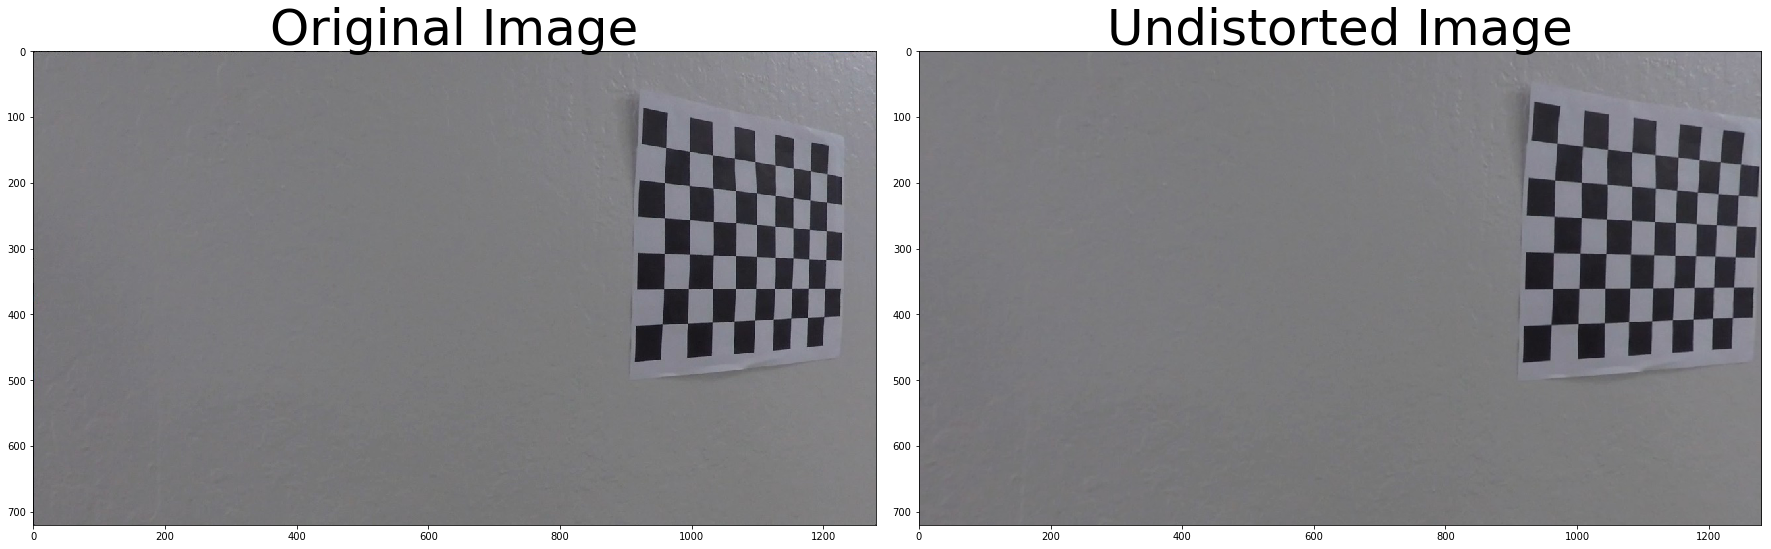

In [5]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [6]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = mpread(pers_img)
    plt.imshow(img)
    src = np.float32([[560, 460], [720, 460], [1250, 720], [40, 720]])
    dst = np.float32([[100, 0], [1060, 0], [1060, 700], [100, 700]])
        
    src = np.float32([[490, 482],[800, 482], [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], [1200, 720],[40, 720]])
    '''
          0   1
           ---
          /   \
         /     \
        /       \
        ---------
       3         2 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


### calculate perspective transformation info and save them in a pickle file

..\test_images\straight_lines1.jpg


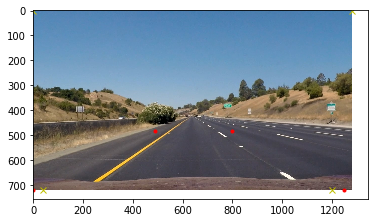

In [7]:
M, Minv = get_perspective_transform_mtx()

import pickle
with open('dump2.pkl', 'wb') as f:
    pickle.dump(
        {
            'M': M,
            'Minv': Minv,
        }, f, pickle.HIGHEST_PROTOCOL)

### reload perspective transformation info from previously saved pickle file


In [8]:
import pickle
with open('dump2.pkl', 'rb') as f:
    pickle_data = pickle.load(f)
    M = pickle_data['M']
    Minv = pickle_data['Minv']

test and check the perspective transformation

In [9]:
import os
def testimg_perspective_transform(m, imgidx = 1):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines' + str(imgidx) + '.jpg')
    print(imgname)
    img = mpread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(warped)


..\test_images\straight_lines1.jpg


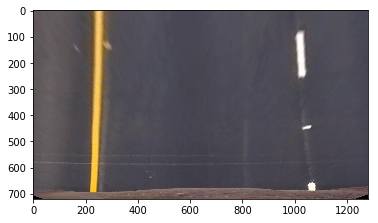

In [10]:
testimg_perspective_transform(M, imgidx = 1)   

..\test_images\straight_lines2.jpg


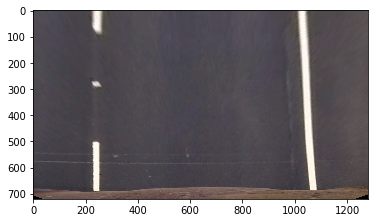

In [11]:
testimg_perspective_transform(M, imgidx = 2)  

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [12]:
from cv2 import Sobel
def build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = None, thresh = (170, 255)):
    if rawtype == 'rgb':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        rgb = img
        luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    elif rawtype == 'bgr':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
    else:
        assert 0, 'rawtype should be bgr or rgb'
    
    channelname = channeltype.lower()
    if channelname ==  'gray':
        channel = gray
    elif channelname == 'rgb_r':
        channel = rgb[:,:,0]
    elif channelname == 'rgb_g':
        channel = rgb[:,:,1]
    elif channelname == 'rgb_b':
        channel = rgb[:,:,2]
    elif channelname == 'hls_h':
        channel = hls[:,:,0]
    elif channelname == 'hls_l':
        channel = hls[:,:,1]
    elif channelname == 'hls_s':
        channel = hls[:,:,2]
    elif channelname == 'luv_l':
        channel = luv[:, :, 0]
    elif channelname == 'luv_u':
        channel = luv[:, :, 1]
    elif channelname == 'luv_v':
        channel = luv[:, :, 2]
    elif channelname == 'lab_l':
        channel = lab[:, :, 0]
    elif channelname == 'lab_a':
        channel = lab[:, :, 1]
    elif channelname == 'lab_b':
        channel = lab[:,:,2]
    else:
        assert 0, 'channel name ' + channelname + ' not valid'
        
    if gradient != None:
        if gradient.lower() == 'x':
            newimg = Sobel(channel, cv2.CV_64F, 1, 0)
        else:
            newimg = Sobel(channel, cv2.CV_64F, 0, 1)
        newimg = np.absolute(newimg)
        newimg = np.int8(255 * newimg / np.max(newimg))
    else:
        newimg = channel
    
    result = np.zeros_like(newimg)
    avg1 = np.mean(np.mean(newimg))
    min1 = np.min(np.min(newimg))
    max1 = np.max(np.max(newimg))
    print('avg=', avg1, ' min=', min1, ' max=', max1)
    result[(newimg >= thresh[0]) & (newimg <= thresh[1])] = 1
    return result


def combine_imgs(bin_img1, bin_img2):
    assert bin_img1.shape == bin_img2.shape
    combined = np.zeros_like(bin_img1)
    combined[(bin_img1 > 0) | (bin_img2 > 0)] = 1
    return combined

def gray_img(bin_img):
    return bin_img * 255

def build_gray_img(color_img, rawtype, channeltype ):
    assert rawtype == 'rgb' or rawtype == 'bgr', 'raw type should be rgb or bgr'
    if  channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'bgr':
        if channeltype == 'rgb_r':
            return color_img[:,:,2]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,0]
    elif channeltype in ['rgb_r', 'rgb_g', 'rgb_b'] and rawtype == 'rgb':
        if channeltype == 'rgb_r':
            return color_img[:,:,0]
        elif channeltype == 'rgb_g':
            return color_img[:,:,1]
        else:
            return color_img[:,:,2]
    elif channeltype in ['hls_h', 'hls_l', 'hls_s']:
        if rawtype == 'bgr':
            img = cv2.cvtColor(color_img, cv2.COLOR_BGR2HLS)
        elif rawtype == 'rgb':
            img = cv2.cvtColor(color_img, cv2.COLOR_RGB2HLS)
            
        if channeltype == 'hls_h':
            return img[:, :, 0]
        elif channeltype == 'hls_l':
            return img[:, :, 1]
        else:
            return img[:, :, 2]
    elif channeltype == 'gray':
        if rawtype == 'rgb':
            return cv2.cvtColor(color_img, cv2.COLOR_RGB2GRAY)
        elif rawtype == 'bgr':
            return cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
        
def bin_img(img, thresh):
    # img should has size 2
    result = np.zeros_like(img)
    result[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return result
    

### test build_binary_img function

In [13]:
import os
def testimg_build_binary(picidx = 6):
    
    imgname = os.path.join('..', 'test_images', 'test' + str(picidx)+'.jpg')
    print('testing the binary img build function on image: ', imgname)
    imgraw = mpread(imgname)
    
    img_undistort = cv2.undistort(imgraw, mtx, dist, None, mtx)
    img = cv2.warpPerspective(img_undistort, M, (img_undistort.shape[1], img_undistort.shape[0]), flags=cv2.INTER_LINEAR)
    
    print('gray img')
    img01 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', thresh = (210,255))
#     img02 = build_binary_img(img, rawtype = 'rgb', channeltype = 'gray', gradient = 'x', thresh= (50, 100))
#     img03 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'gray')
    
#     img04 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', thresh = (200, 255))
#     img05 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_r', gradient = 'x', thresh= (40, 100))
#     img06 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_r')
    
#     img07 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g')
#     img08 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_g', gradient = 'x', thresh= (20, 100))
#     img09 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_g')
    
#     img10 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', thresh = (155, 200))
#     img11 = build_binary_img(img, rawtype = 'rgb', channeltype = 'rgb_b', gradient = 'x', thresh= (20, 100))
#     img12 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'rgb_b')
    
#     img13 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h')
#     img14 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_h', gradient = 'x', thresh= (20, 100))
#     img15 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_h')
    
#     img16 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', thresh = (200, 255))
#     img17 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_l', gradient = 'x', thresh= (20, 100))
#     img18 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_l')
    
#     img19 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', thresh = (180, 255))
#     img20 = build_binary_img(img, rawtype = 'rgb', channeltype = 'hls_s', gradient = 'x', thresh= (20, 100))
#     img21 = build_gray_img(img, rawtype = 'rgb',   channeltype = 'hls_s')
    

    luv_l = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    avg1 = np.mean(np.mean(luv_l))
    max1 = np.max(np.max(luv_l))
    low = avg1 + (max1 - avg1)*3.0/4.0
    high = max1+1
    print('luv_l img, avg =', avg1, 'max =', max1, 'thresh=', low, high)
    img22 = bin_img(luv_l, (low, high))
    # img22 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'luv_l', thresh = (210, 255))   
    

    lab_b = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)[:,:,2]
    avg1 = np.mean(np.mean(lab_b))
    max1 = np.max(np.max(lab_b))
    low = avg1 + (max1 - avg1) *2.0/4.0
    high = max1+1
    print('lab_b img, avg = ', avg1, ' max = ', max1, 'thresh=', low, high)
    img23 = bin_img(lab_b, (low, high))
#     img23 = build_binary_img(img, rawtype = 'rgb',   channeltype = 'lab_b', thresh = (155, 200))
#     img23, avg = build_binary_img(img, rawtype = 'rgb',   channeltype = 'lab_b', thresh = (100, 200))
    
    f, ax = plt.subplots(2, 3, figsize=(48, 18))
    f.tight_layout()
   
    
    ax[0][0].imshow(imgraw)
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow( img_undistort)
    ax[0][1].set_title('undistorted Image', fontsize=32)
    
    ax[0][2].imshow(img)
    ax[0][2].set_title('warp perspective img', fontsize=32)    


    ax[1][0].imshow(gray_img(img01), cmap = 'gray')
    ax[1][0].set_title('gray threshold img', fontsize = 32)
    
#     ax[1][1].imshow(gray_img(img02), cmap = 'gray')
#     ax[1][1].set_title('gray x sobel threshold img', fontsize = 32)
    
#     ax[1][1].imshow(gray_img(img03), cmap = 'gray')
#     ax[1][1].set_title('gray img', fontsize = 32)

    
#     ax[2][0].imshow(gray_img(img04), cmap = 'gray')
#     ax[2][0].set_title('r threshold img', fontsize = 32)
    
#     ax[2][1].imshow(gray_img(img05), cmap = 'gray')
#     ax[2][1].set_title('r x sobel threshold img', fontsize = 32)
    
#     ax[2][2].imshow(img06, cmap = 'gray')
#     ax[2][2].set_title('r img', fontsize = 32)
    
    
#     ax[3][0].imshow(gray_img(img07), cmap = 'gray')
#     ax[3][0].set_title('g threshold img', fontsize = 32)

#     ax[3][1].imshow(gray_img(img08), cmap = 'gray')
#     ax[3][1].set_title('g x sobel threshold img', fontsize = 32)
    
#     ax[3][2].imshow(img09, cmap = 'gray')
#     ax[3][2].set_title('g  img', fontsize = 32)
    
    
#     ax[4][0].imshow(gray_img(img10), cmap = 'gray')
#     ax[4][0].set_title('b threshold img', fontsize = 32)
    
#     ax[4][1].imshow(gray_img(img11), cmap = 'gray')
#     ax[4][1].set_title('b x sobel threshold img', fontsize = 32)
    
#     ax[4][2].imshow(img12, cmap = 'gray')
#     ax[4][2].set_title('b  img', fontsize = 32)
    
    
#     ax[5][0].imshow(gray_img(img13), cmap = 'gray')
#     ax[5][0].set_title('h threshold img', fontsize = 32)
    
#     ax[5][1].imshow(gray_img(img14), cmap = 'gray')
#     ax[5][1].set_title('h x sobel threshold img', fontsize = 32)
    
#     ax[5][2].imshow(img15, cmap = 'gray')
#     ax[5][2].set_title('h  img', fontsize = 32)
    
    
#     ax[6][0].imshow(gray_img(img16), cmap = 'gray')
#     ax[6][0].set_title('l threshold img', fontsize = 32)
    
#     ax[6][1].imshow(gray_img(img17), cmap = 'gray')
#     ax[6][1].set_title('l x sobel threshold img', fontsize = 32)
    
#     ax[6][2].imshow(img18, cmap = 'gray')
#     ax[6][2].set_title('l img', fontsize = 32)
    
    
#     ax[7][0].imshow(gray_img(img19), cmap = 'gray')
#     ax[7][0].set_title('s threshold img', fontsize = 32)
    
#     ax[7][1].imshow(gray_img(img20), cmap = 'gray')
#     ax[7][1].set_title('s x sobel threshold img', fontsize = 32)
    
#     ax[7][2].imshow(img21, cmap = 'gray')
#     ax[7][2].set_title('s  img', fontsize = 32)
    
    
    ax[1][1].imshow(gray_img(img22), cmap = 'gray')
    ax[1][1].set_title('luv l channel threshold img', fontsize = 32)
    
    ax[1][2].imshow(gray_img(img23), cmap = 'gray')
    ax[1][2].set_title('lab b channel threshold img', fontsize = 32)
    
    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # return the raw input img, the img after undistortion and perspective transformation
    return imgraw, img

In [14]:
# img_raw1, img_basic1 = testimg_build_binary(picidx = 1)
# img_raw2, img_basic2 = testimg_build_binary(picidx = 2)
# img_raw3, img_basic3 = testimg_build_binary(picidx = 3)
# img_raw4, img_basic4 = testimg_build_binary(picidx = 4)
# img_raw5, img_basic5 = testimg_build_binary(picidx = 5)
# img_raw6, img_basic6 = testimg_build_binary(picidx = 6)
# img_raw7, img_basic7 = testimg_build_binary(picidx = 7)
# img_raw8, img_basic8 = testimg_build_binary(picidx = 8)
# img_raw9, img_basic9 = testimg_build_binary(picidx = 9)
# img_raw10, img_basic10 = testimg_build_binary(picidx = 10)
# img_raw11, img_basic11 = testimg_build_binary(picidx = 11)
# img_raw12, img_basic12 = testimg_build_binary(picidx = 12)
# img_raw13, img_basic13 = testimg_build_binary(picidx = 13)

In [15]:
def get_histogram(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    # but actually when we detect the base lane x-position, we had better consider the bottom half as the lan maybe curving
    histogram = np.sum( img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))   
    return histogram

In [16]:
# img_basic is the combined binary image we will do lane finding

# histogram = get_histogram(img_basic1)
# histogram = get_histogram(img_basic2)
# histogram = get_histogram(img_basic3)
# histogram = get_histogram(img_basic4)
# histogram = get_histogram(img_basic5)
histogram = get_histogram(img_basic6)

NameError: name 'img_basic6' is not defined

### using the binary image to get the xm_per_pix and ym_per_pix


In [ ]:
import os
def get_xm_per_pix():
    # we use a straight line img, e.g., test_imgs/straignt_lines1.jpg for calc
    # 1. do un-distortion
    # 2. perspective change
    # 3. get the left and right lane distance by pixel
    # 4. comparing with the real value, we assume 3.5m, 
    # return the xm_per_pix
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = mpread(imgname)
    img_size = img.shape[1], img.shape[0]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    color_thresh = (170, 255)
    sobel_thresh = (20, 100)
    
    sobelx = Sobel(gray, cv2.CV_64F, 1, 0)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    sobel_bin = np.zeros_like(sobelx)
    sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 255

    
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    plt.imshow(sobel_bin, cmap = 'gray')
    hist = get_histogram(sobel_bin)
    
    midpoint = np.int(hist.shape[0]/2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    lane_line_pixel = rightx_base - leftx_base
    lane_line_meter = 3.7
    xm_per_pixel = lane_line_meter / lane_line_pixel
    return xm_per_pixel
xm_per_pixel = get_xm_per_pix()        

Sliding Window

### 7. Warp the detected lane boundaries back onto the original image.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

# pipe line for video

In [17]:
def get_threshold_bin_img(img):
    # for video pipeline, the readin img is RGB format
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]
    b_avg = np.mean(np.mean(b_channel))
    b_max = np.max(np.max(b_channel))
    b_thresh_min = 145
    b_thresh_max = 200
#     b_thresh_min = b_avg + (b_max - b_avg)*3.0/4.0
#     b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    l_avg = np.mean(np.mean(l_channel))
    l_max = np.max(np.max(l_channel))
    l_thresh_min = 215
    l_thresh_max = 255
#     l_thresh_min = l_avg + (l_max- l_avg)*3.0/4.0
#     l_thresh_max = l_max
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    gray_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_thresh_min = 210
    gray_thresh_max = 255
    gray_binary = np.zeros_like(gray_channel)
    gray_binary[(gray_channel >= gray_thresh_min) & (gray_channel <= gray_thresh_max)] = 1
    
    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (gray_binary == 1)] = 1
    return combined_binary

In [18]:
def blind_search(img, nwins, left_right, plot_rectangle = True):
    
    xvals = []
    yvals = []
    xsize, ysize = img.shape[1], img.shape[0]
    xmid = int(xsize/2)
    height = np.int(ysize /nwins) 
    x,y = np.nonzero(np.transpose(img))
    block_cnt = 0
    valid_block = []
    for win in range(nwins):
        # loop from img top to bottom
        histogram = np.sum(img[win * height: (win+1)*height, :], axis = 0)
        if left_right == 'left':
            peak = np.argmax(histogram[:xmid])
        else:
            peak = np.argmax(histogram[xmid:]) + xmid

        x_idx = np.where((((peak - 25) < x) & 
                          (x < (peak + 25)) &
                          ((y > win*height) & (y < (win+1)* height))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            xvals.extend(x_window)
            yvals.extend(y_window)
            valid_block.append(win)
            block_cnt += 1
            
        if plot_rectangle:
            cv2.rectangle(img, (peak - 25, win*height), (peak + 25, (win+1) * height), (1), 3) 
    print('blind search, left_right =', left_right, ' valid block is: ', valid_block)
    
    valid = True
    if block_cnt == 2:
        valid = False
        for i in range(nwins//2, nwins, 1):
            if i in valid_block:
                valid = True
    if valid == False:            
#     if block_cnt >1 and len(yvals) >1 and max(yvals) > ysize/2:
        block_cnt = 1
        print('no bottom pixels, reset block_cnt = 1 \n')
    return xvals, yvals, block_cnt 


In [19]:
def based_on_previous_search(img, prev_fittings,nwins):
    # here prev_fittings[0], prev_fittings[1], prev_fittings[2] store previous fitting frame img value
    xvals = []
    yvals = []
    xsize, ysize = img.shape[1], img.shape[0]
    xmid = xsize/2
    height = np.int(ysize /nwins) 
    x,y = np.nonzero(np.transpose(img))
    block_cnt = 0
    valid_block = []
    for win in range(nwins):
        #loop from top to down
        ymid = np.mean([win * height, (win +1) * height])

        xmid = (np.mean(prev_fittings[0]))*ymid**2 +(np.mean(prev_fittings[1]))*ymid + (np.mean(prev_fittings[2]))
        x_idx = np.where((((xmid - 25) < x) & (x < (xmid + 25))&((y > win*height) & (y < (win+1) * height))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            np.append(xvals, x_window)
            np.append(yvals, y_window)
            block_cnt += 1
            valid_block.append(win)
            
    print('based on previous search, valid block=', valid_block)
    valid = True
    if block_cnt ==2:
        valid = False
        for win in range(nwins//2, nwins, 1):
            if win in valid_block:
                valid = True
    if valid == False:
        block_cnt = 1
        print('no bottom pixels, reset block_cnt = 1 \n')
    return xvals, yvals, block_cnt


In [25]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
img_basic6 = cv2.imread('../test_images/test6.jpg')
imgsize = img_basic6.shape[:2]
print(imgsize)

# the difference between LaneLineHandler2 and laneLineHandler is 
# LaneLineHander2 use the previous img left_x_base as the starting point for windows sliding
# while LaneLineHandler use histogram to detect the starting point
class LaneLineHandler2(object):
    def __init__(self, saved_dir = None):
        self.nwindows = 7
        self.window_height = np.int(imgsize[0]/self.nwindows)
        self.margin = 50
        # self.minpix = 50
        self.ym_per_pix = 30./720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
    
        self.mtx = mtx
        self.dist = dist
        
        self.left_reuse_count = 0
        self.right_reuse_count = 0
        
        self.saved_dir = saved_dir
        self.img_count = 0
        self.nodata = False
        
        # for senalty check
        self.last_offset = None
        self.last_left_curvature_meter = None
        self.last_right_curvature_meter = None
        self.last_left_slope = []
        self.last_right_slope = []
        
        self.last_left_fittings = [[], [], [] ]
        self.last_right_fittings = [[], [], []]
        
        self.last_left_fittings_meter = [[], [], [] ]
        self.last_right_fittings_meter = [[], [], []]
        
    def run(self, img):
        self.readin(img)
        self.finding_pixels()
        self.fitting()
        result = self.drawBack()
        return result

        
    def readin(self, img, rawtype = 'rgb'):
       
        # readin the raw color image taken from the camera
        self.img_count += 1
        print('read in the img index:', self.img_count)
        img = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        self.img_raw = img
        self.nodata = False
        
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
        
        self.img_warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        self.img_basic = get_threshold_bin_img(self.img_warped)
        x, y = np.nonzero(np.transpose(self.img_basic))
        if len(x) == 0:
            print('no data for fitting, using previous img')
            self.nodata = True
        return

    
    def finding_pixels(self):
        # we use different strategy to do searching
        print('\n ginding pixels now')
        if self.nodata == True:
            print('no data')
            self.leftx, self.lefty, self.rightx, self.righty = [], [], [], []
            self.left_nodata = True
            self.right_nodata = True
        else:
            self.left_nodata = False
            self.right_nodata = False
            left_block = 0
            right_block = 0
            if self.left_reuse_count >= 4 or self.img_count <= 1:
                print('left_resue count =', self.left_reuse_count, ' doing left blind search')
                self.leftx, self.lefty, left_block = blind_search(self.img_basic, self.nwindows, 'left')
                
            else:
                print('left based previous search')
                self.leftx, self.lefty, left_block = based_on_previous_search(self.img_basic, self.last_left_fittings, self.nwindows)
                if len(self.leftx) == 0:
                    print('left based previous search failed, no data found, switch to blind search')
                    self.leftx, self.lefty, left_block = blind_search(self.img_basic, self.nwindows, 'left')
            
            if self.right_reuse_count >= 4 or self.img_count <= 1:
                print('right_reuse_count =', self.right_reuse_count, ' doing right blind search')
                self.rightx, self.righty, right_block = blind_search(self.img_basic, self.nwindows, 'right')
            else:
                print('right based previous search')
                self.rightx, self.righty, right_block = based_on_previous_search(self.img_basic, self.last_right_fittings, self.nwindows)
                if len(self.rightx) == 0:
                    print('right based on previous search failed, no data found, switch to blind search')
                    self.rightx, self.righty, right_block = blind_search(self.img_basic, self.nwindows, 'right')
            
            if left_block <= 1:
                print('left block <=1, reset left_nodata = True')
                self.left_nodata = True
            if right_block <= 1:
                print('right block <=1, reset right_nodata = True')
                self.right_nodata = True
#             if len(self.leftx) == 0:
#                 self.left_nodata = True
#             if len(self.rightx) == 0:
#                 self.right_nodata = True
            
            
            
    def senaltyCheck(self):
        # we handle left and right separately
        print('\n senaltyCheck begin')
        left_reuse, right_reuse = False, False
        
        # check if need to reuse left
        if self.left_reuse_count >= 20:
            print('too many left_reuse >=20, set reuse to false')
            left_reuse = False
        elif self.img_count <= 1:
            left_reuse = False
        else:
            if self.left_nodata == True:
                print('left lane no data, reuse previous left lane line')
                left_reuse = True
            elif self.left_pos > 600 or self.left_pos < 0:
                print('left_pos=', self.left_pos, ' not reasonable, reuse previous left_pos = ', self.last_left_pos)
#             elif self.last_left_pos != None and abs(self.last_left_pos - self.left_pos) > 50:
#                 print('left lane = ', self.left_pos, ' switched too much, reuse previous left lane line= ', self.last_left_pos)
#                 left_reuse = True
            # elif self.last_left_curvature_meter != None and abs(self.last_left_curvature_meter - self.left_curvature_meter) > 4000:
            #    print('left curvature meter changed too much, reuse previous left lane line')
            #    left_reuse = True
            elif self.left_fit[2] > 1280 or self.left_fit[2] < 0:
                print('left lane top pos not good = ', self.left_fit[2])
                left_resue = True
        
        
        # check if need to reuse right
        if self.right_reuse_count >= 20:
            
            right_reuse = False
        elif self.img_count <= 1:
            right_reuse = False
        else:
            if self.right_nodata == True:
                print('right lane no data, reuse previous right lane line')
                right_reuse = True
            elif self.right_pos > 1280 or self.right_pos < 680:
                print('right lane = ', self.right_pos, ' not reasonable, reuse previous right pos =', self.last_right_pos)
#             elif self.last_right_pos != None and abs(self.last_right_pos - self.right_pos) > 50:
#                 print('right lane =', self.right_pos, 
#                       'switched too much, reuse previous right lane line = ', self.last_right_pos)
#                 right_reuse = True
#             elif self.last_right_curvature_meter != None and abs(self.last_right_curvature_meter - self.right_curvature_meter) > 4000:
#                 print('right curvature meter changed too much, reuse previous left lane line')
#                 right_reuse = True
            elif self.right_fit[2] > 1280 or self.right_fit[2] < 0:
                print('right lane top pos not good = ', self.right_fit[2])
                right_reuse = True
        
                
                
        if left_reuse == True:
            self.left_reuse_count += 1
            self.offset = self.last_offset
            self.left_pos = self.last_left_pos 
            self.left_curvature_meter = self.last_left_curvature_meter
            assert len(self.last_left_fittings[0]) >= 1
            self.left_fit = [ self.last_left_fittings[0][-1],
                            self.last_left_fittings[1][-1],
                            self.last_left_fittings[2][-1]]
            
            self.left_fit_meter = [ self.last_left_fittings_meter[0][-1],
                                   self.last_left_fittings_meter[1][-1],
                                   self.last_left_fittings_meter[2][-1]]
        else:
            self.left_reuse_count = 0
            self.last_offset = self.offset
            self.last_left_curvature_meter = self.left_curvature_meter
            self.last_leftx = self.leftx
            self.last_lefty = self.lefty
            self.last_left_pos = self.left_pos
            for i in range(3):
                self.last_left_fittings[i].append(self.left_fit[i])
                if len(self.last_left_fittings[i]) > 5:
                    self.last_left_fittings[i] = self.last_left_fittings[i][-5:]
                
                self.last_left_fittings_meter[i].append(self.left_fit_meter[i])
                if len(self.last_left_fittings_meter[i]) > 5:
                    self.last_left_fittings_meter[i] = self.last_left_fittings_meter[i][-5:]
                    
        if right_reuse == True:
            self.right_reuse_count += 1
            self.offset = self.last_offset
            self.right_pos = self.last_right_pos
            self.right_curvature_meter = self.last_right_curvature_meter
            assert len(self.last_right_fittings[0]) >= 1
            self.right_fit = [ self.last_right_fittings[0][-1],
                            self.last_right_fittings[1][-1],
                            self.last_right_fittings[2][-1]]
            
            self.right_fit_meter = [ self.last_right_fittings_meter[0][-1],
                                   self.last_right_fittings_meter[1][-1],
                                   self.last_right_fittings_meter[2][-1]]
        else:
            self.right_reuse_count = 0
            self.last_offset = self.offset
            self.last_right_curvature_meter = self.right_curvature_meter
            self.last_rightx = self.rightx
            self.last_righty = self.righty
            self.last_right_pos = self.right_pos
            for i in range(3):
                self.last_right_fittings[i].append(self.right_fit[i])
                if len(self.last_right_fittings[i]) > 5:
                    self.last_right_fittings[i] = self.last_right_fittings[i][-5:]
                
                self.last_right_fittings_meter[i].append(self.right_fit_meter[i])
                if len(self.last_right_fittings_meter[i]) > 5:
                    self.last_right_fittings_meter[i] = self.last_right_fittings_meter[i][-5:]
        
    def fitting(self):
        # no data for current, then do re-use previous frame img pixels
        if len(self.leftx) == 0:
            self.leftx = self.last_leftx
            self.lefty = self.last_lefty
        if len(self.rightx) == 0:
            self.rightx = self.last_rightx
            self.righty = self.last_righty
                
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        
        # self.left_fit_meter = np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2)
        # self.right_fit_meter = np.polyfit(self.righty * self.ym_per_pix, self.rightx * self.xm_per_pix, 2)
        self.left_fit_meter = np.polyfit([y * self.ym_per_pix for y in self.lefty],[x* self.xm_per_pix for x in self.leftx], 2)
        self.right_fit_meter = np.polyfit([y * self.ym_per_pix for y in self.righty], [x*self.xm_per_pix for x in self.rightx], 2)
        
    
    def calcOffset(self):
        car_left = self.left_fit[0]*720**2 + self.left_fit[1]*720 + self.left_fit[2]
        car_right = self.right_fit[0]*720**2 + self.right_fit[1]*720 + self.right_fit[2]
        car_center = (car_left + car_right) /2.0
        self.left_pos = car_left
        self.right_pos = car_right
        # on a general check, the lane top should be in the range of [-20, 1230]
        self.offset = (car_center - 640)* self.xm_per_pix
        
    def calcCurvature(self):
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )

        y_eval = np.max(ploty)
        # calc the curvature at the bottom,e.g., close to the car
        # x = a*y^2 + b*y + c 
        # R_curve = [1 + (2a+b)^2]^(3/2)/ |2a|


        self.left_curvature = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curvature= ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])
        
        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        right_fitting0 = np.mean(self.last_right_fittings[0])
        right_fitting1 = np.mean(self.last_right_fittings[1])
        right_fitting2 = np.mean(self.last_right_fittings[2])
        
        self.left_curvature = ((1 + (2*left_fitting0*y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature= ((1 + (2*right_fitting0*y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
        y_eval = y_eval * self.ym_per_pix
        self.left_curvature_meter =((1 + (2*self.left_fit_meter[0]* y_eval + self.left_fit_meter[1])**2)**1.5) / np.absolute(2*self.left_fit_meter[0])
        self.right_curvature_meter = ((1 + (2*self.right_fit_meter[0] * y_eval + self.right_fit_meter[1])**2)**1.5) / np.absolute(2*self.right_fit_meter[0])
        
        left_fitting0 = np.mean(self.last_left_fittings_meter[0])
        left_fitting1 = np.mean(self.last_left_fittings_meter[1])
        left_fitting2 = np.mean(self.last_left_fittings_meter[2])
        right_fitting0 = np.mean(self.last_right_fittings_meter[0])
        right_fitting1 = np.mean(self.last_right_fittings_meter[1])
        right_fitting2 = np.mean(self.last_right_fittings_meter[2])
        
        self.left_curvature_meter =((1 + (2*left_fitting0* y_eval + left_fitting1)**2)**1.5) / np.absolute(2*left_fitting0)
        self.right_curvature_meter = ((1 + (2*right_fitting0 * y_eval + right_fitting1)**2)**1.5) / np.absolute(2*right_fitting0)
        
    
    def drawBack(self):
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_0raw.jpg'
            mpsave(filename, self.img_raw)
            

        # Create an image to draw the lines on
        color_warp = np.zeros_like(self.img_raw).astype(np.uint8)
        
        ploty = np.linspace(0, self.img_basic.shape[0]-1, self.img_basic.shape[0] )
        
        self.calcOffset()
        self.calcCurvature()
        self.senaltyCheck()

        left_fitting0 = np.mean(self.last_left_fittings[0])
        left_fitting1 = np.mean(self.last_left_fittings[1])
        left_fitting2 = np.mean(self.last_left_fittings[2])
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        left_fitx = left_fitting0*ploty**2 + left_fitting1*ploty + left_fitting2
        
        right_fitting0 = np.mean(self.last_right_fittings[0])
        right_fitting1 = np.mean(self.last_right_fittings[1])
        right_fitting2 = np.mean(self.last_right_fittings[2])
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        right_fitx = right_fitting0 * ploty**2 + right_fitting1*ploty + right_fitting2


        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (self.img_basic.shape[1], self.img_basic.shape[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.img_raw, 1, newwarp, 0.3, 0)
        # plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        
        # write the curvature and position information
        font = cv2.FONT_HERSHEY_SIMPLEX
                
        text = 'Curvature Radius: '+ '{0:.1f}'.format(self.left_curvature_meter/2.0 + self.right_curvature_meter/2.0 ) + ' m'
        cv2.putText(result, text, (50,100), font, 1.5, (255,255,255),2, cv2.LINE_AA)

    
        if self.offset > 0:
            text = 'Vehicle is ' + '{0:.2f}'.format(self.offset) + ' m left of center'
        else:
            text = 'Vehicle is ' + '{0:.2f}'.format(- self.offset) + ' m right of center' 
        cv2.putText(result, text, (50,200), font, 1.5, (255,255,255),2, cv2.LINE_AA)
        
        if self.left_reuse_count == 0:
            text = 'left lane recalc'
        else:
            text = 'reuse left lane= ' + str(self.left_reuse_count)
        if self.right_reuse_count == 0:
            text += '/right lane recalc'
        else:
            text += '/reuse right lane = '+ str(self.right_reuse_count)
            
        cv2.putText(result, text, (50, 300), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
        
        '{0:.2f}'.format(- self.offset)
        text = 'left fitting: {0:.2}, {0:.2}, {0:.2}'.format(self.left_fit[0], self.left_fit[1], self.left_fit[2])
        cv2.putText(result, text, (50, 400), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
        text = 'right fitting: {0:.2}, {0:.2}, {0:.2}'.format(self.right_fit[0], self.right_fit[1], self.right_fit[2])
        cv2.putText(result, text, (50, 500), font, 1.5, (255, 255, 255), 2, cv2.LINE_AA)
        
        if self.saved_dir != None:
            filename = self.saved_dir + str(self.img_count) + '_1warped.jpg'
            cv2.imwrite(filename, self.img_warped)
            filename = self.saved_dir + str(self.img_count) + '_2basic.jpg'
            cv2.imwrite(filename, self.img_basic*255)
            filename = self.saved_dir + str(self.img_count) + '_3result.jpg'
            cv2.imwrite(filename, result)
            
        return result

(720, 1280)


In [26]:
g_handler2 = LaneLineHandler2()
def get_handler2():
    return g_handler2

In [22]:
def process_image2(img):
    handler = get_handler2()
    result = handler.run(img)
    return result

In [28]:

from moviepy.editor import VideoFileClip
challenge_input = '../challenge_video.mp4'
challenge_output = '../challenge_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

# renew handler
g_handler2 = LaneLineHandler2('../videoimg_challenge/')
# g_handler2 = LaneLineHandler2()

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip(challenge_input)
# clip2 = VideoFileClip(challenge_input).subclip(4, 5)
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

read in the img index: 1

 ginding pixels now
left_resue count = 0  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 0  doing right blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin
[MoviePy] >>>> Building video ../challenge_solution.mp4
[MoviePy] Writing video ../challenge_solution.mp4


  0%|                                                                          | 0/485 [00:00<?, ?it/s]

read in the img index: 2

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


  0%|▏                                                                 | 1/485 [00:01<10:03,  1.25s/it]

read in the img index: 3

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


  0%|▎                                                                 | 2/485 [00:02<10:31,  1.31s/it]

read in the img index: 4

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


  1%|▍                                                                 | 3/485 [00:03<10:12,  1.27s/it]

read in the img index: 5

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


  1%|▌                                                                 | 4/485 [00:05<09:59,  1.25s/it]

read in the img index: 6

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [6]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  1%|▋                                                                 | 5/485 [00:06<10:00,  1.25s/it]

read in the img index: 7

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [6]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  1%|▊                                                                 | 6/485 [00:07<10:09,  1.27s/it]

read in the img index: 8

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= []
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  1%|▉                                                                 | 7/485 [00:08<10:03,  1.26s/it]

read in the img index: 9

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= []
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  2%|█                                                                 | 8/485 [00:10<10:07,  1.27s/it]

read in the img index: 10

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right_reuse_count = 4  doing right blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  2%|█▏                                                                | 9/485 [00:11<10:06,  1.27s/it]

read in the img index: 11

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right_reuse_count = 5  doing right blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  2%|█▎                                                               | 10/485 [00:12<10:14,  1.29s/it]

read in the img index: 12

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right_reuse_count = 6  doing right blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  2%|█▍                                                               | 11/485 [00:14<10:04,  1.28s/it]

read in the img index: 13

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right_reuse_count = 7  doing right blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  2%|█▌                                                               | 12/485 [00:15<09:55,  1.26s/it]

read in the img index: 14

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right_reuse_count = 8  doing right blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  3%|█▋                                                               | 13/485 [00:16<09:48,  1.25s/it]

read in the img index: 15

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right_reuse_count = 9  doing right blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  3%|█▉                                                               | 14/485 [00:17<09:39,  1.23s/it]

read in the img index: 16

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right_reuse_count = 10  doing right blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  3%|██                                                               | 15/485 [00:18<09:40,  1.24s/it]

read in the img index: 17

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right_reuse_count = 11  doing right blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin
right lane top pos not good =  1420.04651578


  3%|██▏                                                              | 16/485 [00:20<09:30,  1.22s/it]

read in the img index: 18

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 12  doing right blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin
right lane top pos not good =  1481.55840324


  4%|██▎                                                              | 17/485 [00:21<09:35,  1.23s/it]

read in the img index: 19

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right_reuse_count = 13  doing right blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin
right lane top pos not good =  1333.0089071


  4%|██▍                                                              | 18/485 [00:22<09:28,  1.22s/it]

read in the img index: 20

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 14  doing right blind search
blind search, left_right = right  valid block is:  [6]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  4%|██▌                                                              | 19/485 [00:23<09:21,  1.20s/it]

read in the img index: 21

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right_reuse_count = 15  doing right blind search
blind search, left_right = right  valid block is:  [3, 6]

 senaltyCheck begin


  4%|██▋                                                              | 20/485 [00:24<09:15,  1.19s/it]

read in the img index: 22

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  4%|██▊                                                              | 21/485 [00:26<09:14,  1.20s/it]

read in the img index: 23

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  5%|██▉                                                              | 22/485 [00:27<09:16,  1.20s/it]

read in the img index: 24

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


  5%|███                                                              | 23/485 [00:28<09:13,  1.20s/it]

read in the img index: 25

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


  5%|███▏                                                             | 24/485 [00:29<09:09,  1.19s/it]

read in the img index: 26

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


  5%|███▎                                                             | 25/485 [00:30<09:14,  1.20s/it]

read in the img index: 27

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


  5%|███▍                                                             | 26/485 [00:32<09:26,  1.23s/it]

read in the img index: 28

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


  6%|███▌                                                             | 27/485 [00:33<09:19,  1.22s/it]

read in the img index: 29

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


  6%|███▊                                                             | 28/485 [00:34<09:13,  1.21s/it]

read in the img index: 30

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


  6%|███▉                                                             | 29/485 [00:35<09:08,  1.20s/it]

read in the img index: 31

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


  6%|████                                                             | 30/485 [00:37<09:21,  1.23s/it]

read in the img index: 32

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


  6%|████▏                                                            | 31/485 [00:38<10:12,  1.35s/it]

read in the img index: 33

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


  7%|████▎                                                            | 32/485 [00:40<11:11,  1.48s/it]

read in the img index: 34

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


  7%|████▍                                                            | 33/485 [00:42<11:38,  1.54s/it]

read in the img index: 35

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


  7%|████▌                                                            | 34/485 [00:43<11:33,  1.54s/it]

read in the img index: 36

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 6]

 senaltyCheck begin


  7%|████▋                                                            | 35/485 [00:45<11:33,  1.54s/it]

read in the img index: 37

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


  7%|████▊                                                            | 36/485 [00:46<11:32,  1.54s/it]

read in the img index: 38

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


  8%|████▉                                                            | 37/485 [00:48<11:34,  1.55s/it]

read in the img index: 39

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


  8%|█████                                                            | 38/485 [00:49<11:27,  1.54s/it]

read in the img index: 40

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


  8%|█████▏                                                           | 39/485 [00:51<11:21,  1.53s/it]

read in the img index: 41

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


  8%|█████▎                                                           | 40/485 [00:52<11:15,  1.52s/it]

read in the img index: 42

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


  8%|█████▍                                                           | 41/485 [00:54<11:17,  1.53s/it]

read in the img index: 43

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


  9%|█████▋                                                           | 42/485 [00:55<11:13,  1.52s/it]

read in the img index: 44

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


  9%|█████▊                                                           | 43/485 [00:57<11:33,  1.57s/it]

read in the img index: 45

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


  9%|█████▉                                                           | 44/485 [00:59<11:32,  1.57s/it]

read in the img index: 46

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


  9%|██████                                                           | 45/485 [01:00<11:16,  1.54s/it]

read in the img index: 47

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


  9%|██████▏                                                          | 46/485 [01:02<11:09,  1.53s/it]

read in the img index: 48

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 10%|██████▎                                                          | 47/485 [01:03<11:03,  1.52s/it]

read in the img index: 49

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 6]

 senaltyCheck begin


 10%|██████▍                                                          | 48/485 [01:04<10:21,  1.42s/it]

read in the img index: 50

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 6]

 senaltyCheck begin


 10%|██████▌                                                          | 49/485 [01:06<10:05,  1.39s/it]

read in the img index: 51

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 5]

 senaltyCheck begin


 10%|██████▋                                                          | 50/485 [01:07<10:05,  1.39s/it]

read in the img index: 52

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 11%|██████▊                                                          | 51/485 [01:08<10:12,  1.41s/it]

read in the img index: 53

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 6]

 senaltyCheck begin


 11%|██████▉                                                          | 52/485 [01:10<09:54,  1.37s/it]

read in the img index: 54

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 11%|███████                                                          | 53/485 [01:11<09:55,  1.38s/it]

read in the img index: 55

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 11%|███████▏                                                         | 54/485 [01:13<10:31,  1.47s/it]

read in the img index: 56

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 11%|███████▎                                                         | 55/485 [01:14<10:15,  1.43s/it]

read in the img index: 57

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 12%|███████▌                                                         | 56/485 [01:16<10:17,  1.44s/it]

read in the img index: 58

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 12%|███████▋                                                         | 57/485 [01:17<10:02,  1.41s/it]

read in the img index: 59

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 12%|███████▊                                                         | 58/485 [01:19<10:37,  1.49s/it]

read in the img index: 60

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 12%|███████▉                                                         | 59/485 [01:20<11:09,  1.57s/it]

read in the img index: 61

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 12%|████████                                                         | 60/485 [01:22<12:05,  1.71s/it]

read in the img index: 62

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [6]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 13%|████████▏                                                        | 61/485 [01:24<11:49,  1.67s/it]

read in the img index: 63

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 6]

 senaltyCheck begin


 13%|████████▎                                                        | 62/485 [01:26<11:45,  1.67s/it]

read in the img index: 64

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 6]

 senaltyCheck begin


 13%|████████▍                                                        | 63/485 [01:27<11:15,  1.60s/it]

read in the img index: 65

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 5]

 senaltyCheck begin


 13%|████████▌                                                        | 64/485 [01:29<10:51,  1.55s/it]

read in the img index: 66

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 13%|████████▋                                                        | 65/485 [01:30<10:55,  1.56s/it]

read in the img index: 67

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 6]

 senaltyCheck begin


 14%|████████▊                                                        | 66/485 [01:32<11:00,  1.58s/it]

read in the img index: 68

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 14%|████████▉                                                        | 67/485 [01:33<10:30,  1.51s/it]

read in the img index: 69

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 14%|█████████                                                        | 68/485 [01:35<12:17,  1.77s/it]

read in the img index: 70

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 14%|█████████▏                                                       | 69/485 [01:37<12:09,  1.75s/it]

read in the img index: 71

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 14%|█████████▍                                                       | 70/485 [01:39<11:34,  1.67s/it]

read in the img index: 72

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 15%|█████████▌                                                       | 71/485 [01:40<11:05,  1.61s/it]

read in the img index: 73

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 15%|█████████▋                                                       | 72/485 [01:42<10:57,  1.59s/it]

read in the img index: 74

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 15%|█████████▊                                                       | 73/485 [01:43<10:58,  1.60s/it]

read in the img index: 75

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 15%|█████████▉                                                       | 74/485 [01:45<10:36,  1.55s/it]

read in the img index: 76

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 15%|██████████                                                       | 75/485 [01:46<10:55,  1.60s/it]

read in the img index: 77

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 16%|██████████▏                                                      | 76/485 [01:48<10:31,  1.54s/it]

read in the img index: 78

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5, 6]

 senaltyCheck begin


 16%|██████████▎                                                      | 77/485 [01:49<10:20,  1.52s/it]

read in the img index: 79

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5]

 senaltyCheck begin


 16%|██████████▍                                                      | 78/485 [01:51<10:05,  1.49s/it]

read in the img index: 80

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 16%|██████████▌                                                      | 79/485 [01:52<09:55,  1.47s/it]

read in the img index: 81

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 16%|██████████▋                                                      | 80/485 [01:54<09:55,  1.47s/it]

read in the img index: 82

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 17%|██████████▊                                                      | 81/485 [01:55<09:45,  1.45s/it]

read in the img index: 83

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 17%|██████████▉                                                      | 82/485 [01:57<09:45,  1.45s/it]

read in the img index: 84

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 17%|███████████                                                      | 83/485 [01:58<09:39,  1.44s/it]

read in the img index: 85

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 17%|███████████▎                                                     | 84/485 [01:59<09:35,  1.44s/it]

read in the img index: 86

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 18%|███████████▍                                                     | 85/485 [02:01<09:36,  1.44s/it]

read in the img index: 87

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 5, 6]

 senaltyCheck begin


 18%|███████████▌                                                     | 86/485 [02:02<09:46,  1.47s/it]

read in the img index: 88

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 18%|███████████▋                                                     | 87/485 [02:04<09:23,  1.42s/it]

read in the img index: 89

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 18%|███████████▊                                                     | 88/485 [02:05<09:08,  1.38s/it]

read in the img index: 90

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 18%|███████████▉                                                     | 89/485 [02:07<09:28,  1.44s/it]

read in the img index: 91

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 19%|████████████                                                     | 90/485 [02:08<09:36,  1.46s/it]

read in the img index: 92

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5, 6]

 senaltyCheck begin


 19%|████████████▏                                                    | 91/485 [02:09<09:06,  1.39s/it]

read in the img index: 93

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 19%|████████████▎                                                    | 92/485 [02:11<09:31,  1.45s/it]

read in the img index: 94

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 19%|████████████▍                                                    | 93/485 [02:12<09:06,  1.39s/it]

read in the img index: 95

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 19%|████████████▌                                                    | 94/485 [02:14<09:29,  1.46s/it]

read in the img index: 96

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 20%|████████████▋                                                    | 95/485 [02:16<10:08,  1.56s/it]

read in the img index: 97

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 20%|████████████▊                                                    | 96/485 [02:17<09:23,  1.45s/it]

read in the img index: 98

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 20%|█████████████                                                    | 97/485 [02:19<10:40,  1.65s/it]

read in the img index: 99

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 20%|█████████████▏                                                   | 98/485 [02:20<10:23,  1.61s/it]

read in the img index: 100

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5, 6]

 senaltyCheck begin


 20%|█████████████▎                                                   | 99/485 [02:22<10:01,  1.56s/it]

read in the img index: 101

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 21%|█████████████▏                                                  | 100/485 [02:24<10:23,  1.62s/it]

read in the img index: 102

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 21%|█████████████▎                                                  | 101/485 [02:25<09:33,  1.49s/it]

read in the img index: 103

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 21%|█████████████▍                                                  | 102/485 [02:27<11:45,  1.84s/it]

read in the img index: 104

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 21%|█████████████▌                                                  | 103/485 [02:29<11:23,  1.79s/it]

read in the img index: 105

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 21%|█████████████▋                                                  | 104/485 [02:31<10:52,  1.71s/it]

read in the img index: 106

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 22%|█████████████▊                                                  | 105/485 [02:33<11:36,  1.83s/it]

read in the img index: 107

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5]

 senaltyCheck begin


 22%|█████████████▉                                                  | 106/485 [02:35<12:07,  1.92s/it]

read in the img index: 108

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5, 6]

 senaltyCheck begin


 22%|██████████████                                                  | 107/485 [02:36<10:56,  1.74s/it]

read in the img index: 109

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 22%|██████████████▎                                                 | 108/485 [02:38<10:43,  1.71s/it]

read in the img index: 110

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 22%|██████████████▍                                                 | 109/485 [02:39<10:05,  1.61s/it]

read in the img index: 111

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 5]

 senaltyCheck begin


 23%|██████████████▌                                                 | 110/485 [02:41<10:57,  1.75s/it]

read in the img index: 112

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 23%|██████████████▋                                                 | 111/485 [02:43<10:36,  1.70s/it]

read in the img index: 113

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 23%|██████████████▊                                                 | 112/485 [02:44<10:27,  1.68s/it]

read in the img index: 114

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5, 6]

 senaltyCheck begin


 23%|██████████████▉                                                 | 113/485 [02:46<10:42,  1.73s/it]

read in the img index: 115

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 5, 6]

 senaltyCheck begin


 24%|███████████████                                                 | 114/485 [02:48<10:23,  1.68s/it]

read in the img index: 116

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 24%|███████████████▏                                                | 115/485 [02:50<10:33,  1.71s/it]

read in the img index: 117

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 24%|███████████████▎                                                | 116/485 [02:51<10:24,  1.69s/it]

read in the img index: 118

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 6]

 senaltyCheck begin


 24%|███████████████▍                                                | 117/485 [02:53<10:10,  1.66s/it]

read in the img index: 119

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 24%|███████████████▌                                                | 118/485 [02:54<09:33,  1.56s/it]

read in the img index: 120

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 4, 6]

 senaltyCheck begin


 25%|███████████████▋                                                | 119/485 [02:56<09:36,  1.58s/it]

read in the img index: 121

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 4, 5]

 senaltyCheck begin


 25%|███████████████▊                                                | 120/485 [02:57<09:34,  1.57s/it]

read in the img index: 122

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 25%|███████████████▉                                                | 121/485 [02:59<09:37,  1.59s/it]

read in the img index: 123

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 25%|████████████████                                                | 122/485 [03:00<09:14,  1.53s/it]

read in the img index: 124

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 25%|████████████████▏                                               | 123/485 [03:02<08:50,  1.47s/it]

read in the img index: 125

 ginding pixels now
left based previous search
based on previous search, valid block= [4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5, 6]

 senaltyCheck begin


 26%|████████████████▎                                               | 124/485 [03:03<09:10,  1.52s/it]

read in the img index: 126

 ginding pixels now
left based previous search
based on previous search, valid block= [4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 26%|████████████████▍                                               | 125/485 [03:05<08:50,  1.47s/it]

read in the img index: 127

 ginding pixels now
left based previous search
based on previous search, valid block= [4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 26%|████████████████▋                                               | 126/485 [03:07<09:19,  1.56s/it]

read in the img index: 128

 ginding pixels now
left based previous search
based on previous search, valid block= [4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 26%|████████████████▊                                               | 127/485 [03:08<08:38,  1.45s/it]

read in the img index: 129

 ginding pixels now
left based previous search
based on previous search, valid block= [4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 26%|████████████████▉                                               | 128/485 [03:09<08:59,  1.51s/it]

read in the img index: 130

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 27%|█████████████████                                               | 129/485 [03:10<08:09,  1.37s/it]

read in the img index: 131

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 27%|█████████████████▏                                              | 130/485 [03:12<08:14,  1.39s/it]

read in the img index: 132

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [5, 6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [6]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 27%|█████████████████▎                                              | 131/485 [03:13<07:18,  1.24s/it]

read in the img index: 133

 ginding pixels now
left based previous search
based on previous search, valid block= [6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [6]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 27%|█████████████████▍                                              | 132/485 [03:14<07:22,  1.25s/it]

read in the img index: 134

 ginding pixels now
left based previous search
based on previous search, valid block= [6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [6]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 27%|█████████████████▌                                              | 133/485 [03:15<07:37,  1.30s/it]

read in the img index: 135
no data for fitting, using previous img

 ginding pixels now
no data

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 28%|█████████████████▋                                              | 134/485 [03:17<07:31,  1.29s/it]

read in the img index: 136

 ginding pixels now
left based previous search
based on previous search, valid block= []
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  []
right_reuse_count = 4  doing right blind search
blind search, left_right = right  valid block is:  [0]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 28%|█████████████████▊                                              | 135/485 [03:18<07:45,  1.33s/it]

read in the img index: 137

 ginding pixels now
left_resue count = 4  doing left blind search
blind search, left_right = left  valid block is:  []
right_reuse_count = 5  doing right blind search
blind search, left_right = right  valid block is:  [0]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 28%|█████████████████▉                                              | 136/485 [03:19<07:44,  1.33s/it]

read in the img index: 138

 ginding pixels now
left_resue count = 5  doing left blind search
blind search, left_right = left  valid block is:  []
right_reuse_count = 6  doing right blind search
blind search, left_right = right  valid block is:  [0]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 28%|██████████████████                                              | 137/485 [03:20<06:59,  1.20s/it]

read in the img index: 139

 ginding pixels now
left_resue count = 6  doing left blind search
blind search, left_right = left  valid block is:  []
right_reuse_count = 7  doing right blind search
blind search, left_right = right  valid block is:  [0]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 28%|██████████████████▏                                             | 138/485 [03:22<07:02,  1.22s/it]

read in the img index: 140

 ginding pixels now
left_resue count = 7  doing left blind search
blind search, left_right = left  valid block is:  [0]
right_reuse_count = 8  doing right blind search
blind search, left_right = right  valid block is:  [0, 1]
no bottom pixels, reset block_cnt = 1 

left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 29%|██████████████████▎                                             | 139/485 [03:23<07:05,  1.23s/it]

read in the img index: 141

 ginding pixels now
left_resue count = 8  doing left blind search
blind search, left_right = left  valid block is:  []
right_reuse_count = 9  doing right blind search
blind search, left_right = right  valid block is:  [0, 1]
no bottom pixels, reset block_cnt = 1 

left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 29%|██████████████████▍                                             | 140/485 [03:24<06:52,  1.20s/it]

read in the img index: 142

 ginding pixels now
left_resue count = 9  doing left blind search
blind search, left_right = left  valid block is:  [0, 1]
no bottom pixels, reset block_cnt = 1 

right_reuse_count = 10  doing right blind search
blind search, left_right = right  valid block is:  [1]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 29%|██████████████████▌                                             | 141/485 [03:25<06:32,  1.14s/it]

read in the img index: 143

 ginding pixels now
left_resue count = 10  doing left blind search
blind search, left_right = left  valid block is:  [0, 1]
no bottom pixels, reset block_cnt = 1 

right_reuse_count = 11  doing right blind search
blind search, left_right = right  valid block is:  [1, 2]
no bottom pixels, reset block_cnt = 1 

left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 29%|██████████████████▋                                             | 142/485 [03:27<07:13,  1.26s/it]

read in the img index: 144

 ginding pixels now
left_resue count = 11  doing left blind search
blind search, left_right = left  valid block is:  [0, 1]
no bottom pixels, reset block_cnt = 1 

right_reuse_count = 12  doing right blind search
blind search, left_right = right  valid block is:  [1, 2]
no bottom pixels, reset block_cnt = 1 

left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 29%|██████████████████▊                                             | 143/485 [03:28<06:48,  1.20s/it]

read in the img index: 145

 ginding pixels now
left_resue count = 12  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2]
right_reuse_count = 13  doing right blind search
blind search, left_right = right  valid block is:  [1, 2]
no bottom pixels, reset block_cnt = 1 

right block <=1, reset right_nodata = True

 senaltyCheck begin
left_pos= -50.6815730567  not reasonable, reuse previous left_pos =  307.347063149
right lane no data, reuse previous right lane line


 30%|███████████████████                                             | 144/485 [03:29<07:11,  1.26s/it]

read in the img index: 146

 ginding pixels now
left based previous search
based on previous search, valid block= []
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2]
no bottom pixels, reset block_cnt = 1 

right_reuse_count = 14  doing right blind search
blind search, left_right = right  valid block is:  [2]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 30%|███████████████████▏                                            | 145/485 [03:30<06:43,  1.19s/it]

read in the img index: 147

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2]
no bottom pixels, reset block_cnt = 1 

left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2]
no bottom pixels, reset block_cnt = 1 

right_reuse_count = 15  doing right blind search
blind search, left_right = right  valid block is:  [2]
left block <=1, reset left_nodata = True
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane no data, reuse previous right lane line


 30%|███████████████████▎                                            | 146/485 [03:31<07:12,  1.28s/it]

read in the img index: 148

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2]
no bottom pixels, reset block_cnt = 1 

left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2]
no bottom pixels, reset block_cnt = 1 

right_reuse_count = 16  doing right blind search
blind search, left_right = right  valid block is:  [2, 3]
left block <=1, reset left_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane =  1442.78757903  not reasonable, reuse previous right pos = 1019.3174235


 30%|███████████████████▍                                            | 147/485 [03:33<06:53,  1.22s/it]

read in the img index: 149

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3]
right based previous search
based on previous search, valid block= [0, 1, 2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3]

 senaltyCheck begin


 31%|███████████████████▌                                            | 148/485 [03:34<07:47,  1.39s/it]

read in the img index: 150

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3]
right based previous search
based on previous search, valid block= [0, 1, 2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3]

 senaltyCheck begin


 31%|███████████████████▋                                            | 149/485 [03:36<07:25,  1.33s/it]

read in the img index: 151

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3]
right based previous search
based on previous search, valid block= [0, 1, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4]

 senaltyCheck begin


 31%|███████████████████▊                                            | 150/485 [03:37<08:10,  1.46s/it]

read in the img index: 152

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4]

 senaltyCheck begin


 31%|███████████████████▉                                            | 151/485 [03:38<07:30,  1.35s/it]

read in the img index: 153

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4]

 senaltyCheck begin


 31%|████████████████████                                            | 152/485 [03:40<07:49,  1.41s/it]

read in the img index: 154

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4]
right based previous search
based on previous search, valid block= [0, 1, 2, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 4, 5]

 senaltyCheck begin


 32%|████████████████████▏                                           | 153/485 [03:41<07:53,  1.43s/it]

read in the img index: 155

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5]

 senaltyCheck begin


 32%|████████████████████▎                                           | 154/485 [03:43<07:49,  1.42s/it]

read in the img index: 156

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5]

 senaltyCheck begin


 32%|████████████████████▍                                           | 155/485 [03:44<07:42,  1.40s/it]

read in the img index: 157

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 3, 5, 6]

 senaltyCheck begin


 32%|████████████████████▌                                           | 156/485 [03:46<08:00,  1.46s/it]

read in the img index: 158

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 3, 5, 6]

 senaltyCheck begin


 32%|████████████████████▋                                           | 157/485 [03:47<08:01,  1.47s/it]

read in the img index: 159

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5, 6]

 senaltyCheck begin


 33%|████████████████████▊                                           | 158/485 [03:49<08:05,  1.49s/it]

read in the img index: 160

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 3, 4, 6]

 senaltyCheck begin


 33%|████████████████████▉                                           | 159/485 [03:50<07:52,  1.45s/it]

read in the img index: 161

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 4, 6]

 senaltyCheck begin


 33%|█████████████████████                                           | 160/485 [03:52<08:04,  1.49s/it]

read in the img index: 162

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 33%|█████████████████████▏                                          | 161/485 [03:53<07:46,  1.44s/it]

read in the img index: 163

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 33%|█████████████████████▍                                          | 162/485 [03:55<08:04,  1.50s/it]

read in the img index: 164

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 34%|█████████████████████▌                                          | 163/485 [03:56<07:31,  1.40s/it]

read in the img index: 165

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 34%|█████████████████████▋                                          | 164/485 [03:57<07:48,  1.46s/it]

read in the img index: 166

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 34%|█████████████████████▊                                          | 165/485 [03:59<07:45,  1.46s/it]

read in the img index: 167

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5, 6]

 senaltyCheck begin


 34%|█████████████████████▉                                          | 166/485 [04:01<08:14,  1.55s/it]

read in the img index: 168

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 34%|██████████████████████                                          | 167/485 [04:02<07:58,  1.51s/it]

read in the img index: 169

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 35%|██████████████████████▏                                         | 168/485 [04:04<08:25,  1.59s/it]

read in the img index: 170

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 35%|██████████████████████▎                                         | 169/485 [04:05<08:11,  1.56s/it]

read in the img index: 171

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 35%|██████████████████████▍                                         | 170/485 [04:07<08:33,  1.63s/it]

read in the img index: 172

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 35%|██████████████████████▌                                         | 171/485 [04:09<08:46,  1.68s/it]

read in the img index: 173

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 6]

 senaltyCheck begin


 35%|██████████████████████▋                                         | 172/485 [04:10<08:28,  1.62s/it]

read in the img index: 174

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 36%|██████████████████████▊                                         | 173/485 [04:12<08:46,  1.69s/it]

read in the img index: 175

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 4, 6]

 senaltyCheck begin


 36%|██████████████████████▉                                         | 174/485 [04:14<08:21,  1.61s/it]

read in the img index: 176

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 36%|███████████████████████                                         | 175/485 [04:15<08:22,  1.62s/it]

read in the img index: 177

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 4, 5]

 senaltyCheck begin


 36%|███████████████████████▏                                        | 176/485 [04:17<07:41,  1.49s/it]

read in the img index: 178

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 36%|███████████████████████▎                                        | 177/485 [04:18<08:04,  1.57s/it]

read in the img index: 179

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 37%|███████████████████████▍                                        | 178/485 [04:20<07:41,  1.50s/it]

read in the img index: 180

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 5, 6]

 senaltyCheck begin


 37%|███████████████████████▌                                        | 179/485 [04:22<08:12,  1.61s/it]

read in the img index: 181

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 37%|███████████████████████▊                                        | 180/485 [04:23<08:01,  1.58s/it]

read in the img index: 182

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 37%|███████████████████████▉                                        | 181/485 [04:25<08:09,  1.61s/it]

read in the img index: 183

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5, 6]

 senaltyCheck begin


 38%|████████████████████████                                        | 182/485 [04:26<08:24,  1.66s/it]

read in the img index: 184

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 3, 5, 6]

 senaltyCheck begin


 38%|████████████████████████▏                                       | 183/485 [04:28<08:06,  1.61s/it]

read in the img index: 185

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 3, 5, 6]

 senaltyCheck begin


 38%|████████████████████████▎                                       | 184/485 [04:30<08:19,  1.66s/it]

read in the img index: 186

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 3, 5, 6]

 senaltyCheck begin


 38%|████████████████████████▍                                       | 185/485 [04:32<08:29,  1.70s/it]

read in the img index: 187

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 6]

 senaltyCheck begin


 38%|████████████████████████▌                                       | 186/485 [04:33<08:42,  1.75s/it]

read in the img index: 188

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 4, 6]

 senaltyCheck begin


 39%|████████████████████████▋                                       | 187/485 [04:35<08:47,  1.77s/it]

read in the img index: 189

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 4, 6]

 senaltyCheck begin


 39%|████████████████████████▊                                       | 188/485 [04:37<08:38,  1.74s/it]

read in the img index: 190

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 39%|████████████████████████▉                                       | 189/485 [04:39<08:28,  1.72s/it]

read in the img index: 191

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 39%|█████████████████████████                                       | 190/485 [04:41<09:15,  1.88s/it]

read in the img index: 192

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 39%|█████████████████████████▏                                      | 191/485 [04:43<09:57,  2.03s/it]

read in the img index: 193

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 40%|█████████████████████████▎                                      | 192/485 [04:45<09:41,  1.98s/it]

read in the img index: 194

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 5, 6]

 senaltyCheck begin


 40%|█████████████████████████▍                                      | 193/485 [04:47<09:54,  2.03s/it]

read in the img index: 195

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5, 6]

 senaltyCheck begin


 40%|█████████████████████████▌                                      | 194/485 [04:49<09:06,  1.88s/it]

read in the img index: 196

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 40%|█████████████████████████▋                                      | 195/485 [04:50<08:20,  1.73s/it]

read in the img index: 197

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5, 6]

 senaltyCheck begin


 40%|█████████████████████████▊                                      | 196/485 [04:52<08:06,  1.68s/it]

read in the img index: 198

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 41%|█████████████████████████▉                                      | 197/485 [04:53<07:52,  1.64s/it]

read in the img index: 199

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 41%|██████████████████████████▏                                     | 198/485 [04:55<07:44,  1.62s/it]

read in the img index: 200

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5, 6]

 senaltyCheck begin


 41%|██████████████████████████▎                                     | 199/485 [04:56<07:38,  1.60s/it]

read in the img index: 201

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 4, 6]

 senaltyCheck begin


 41%|██████████████████████████▍                                     | 200/485 [04:58<07:31,  1.58s/it]

read in the img index: 202

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 4, 6]

 senaltyCheck begin


 41%|██████████████████████████▌                                     | 201/485 [04:59<07:21,  1.55s/it]

read in the img index: 203

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 42%|██████████████████████████▋                                     | 202/485 [05:01<07:30,  1.59s/it]

read in the img index: 204

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 42%|██████████████████████████▊                                     | 203/485 [05:02<07:02,  1.50s/it]

read in the img index: 205

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 42%|██████████████████████████▉                                     | 204/485 [05:04<07:12,  1.54s/it]

read in the img index: 206

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 42%|███████████████████████████                                     | 205/485 [05:05<06:38,  1.42s/it]

read in the img index: 207

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 42%|███████████████████████████▏                                    | 206/485 [05:07<07:07,  1.53s/it]

read in the img index: 208

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 43%|███████████████████████████▎                                    | 207/485 [05:08<06:50,  1.48s/it]

read in the img index: 209

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 43%|███████████████████████████▍                                    | 208/485 [05:10<07:06,  1.54s/it]

read in the img index: 210

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 43%|███████████████████████████▌                                    | 209/485 [05:11<06:32,  1.42s/it]

read in the img index: 211

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 43%|███████████████████████████▋                                    | 210/485 [05:13<06:57,  1.52s/it]

read in the img index: 212

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 44%|███████████████████████████▊                                    | 211/485 [05:14<06:20,  1.39s/it]

read in the img index: 213

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 44%|███████████████████████████▉                                    | 212/485 [05:15<06:30,  1.43s/it]

read in the img index: 214

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 6]

 senaltyCheck begin


 44%|████████████████████████████                                    | 213/485 [05:17<06:07,  1.35s/it]

read in the img index: 215

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 6]

 senaltyCheck begin


 44%|████████████████████████████▏                                   | 214/485 [05:18<06:36,  1.46s/it]

read in the img index: 216

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 6]

 senaltyCheck begin


 44%|████████████████████████████▎                                   | 215/485 [05:19<06:06,  1.36s/it]

read in the img index: 217

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 45%|████████████████████████████▌                                   | 216/485 [05:21<06:26,  1.44s/it]

read in the img index: 218

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 45%|████████████████████████████▋                                   | 217/485 [05:22<06:04,  1.36s/it]

read in the img index: 219

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 45%|████████████████████████████▊                                   | 218/485 [05:24<06:33,  1.47s/it]

read in the img index: 220

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 45%|████████████████████████████▉                                   | 219/485 [05:25<06:21,  1.43s/it]

read in the img index: 221

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 45%|█████████████████████████████                                   | 220/485 [05:27<06:15,  1.42s/it]

read in the img index: 222

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5, 6]

 senaltyCheck begin


 46%|█████████████████████████████▏                                  | 221/485 [05:28<05:56,  1.35s/it]

read in the img index: 223

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 46%|█████████████████████████████▎                                  | 222/485 [05:29<06:10,  1.41s/it]

read in the img index: 224

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 46%|█████████████████████████████▍                                  | 223/485 [05:31<06:16,  1.44s/it]

read in the img index: 225

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 46%|█████████████████████████████▌                                  | 224/485 [05:34<07:52,  1.81s/it]

read in the img index: 226

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 46%|█████████████████████████████▋                                  | 225/485 [05:35<07:46,  1.79s/it]

read in the img index: 227

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 47%|█████████████████████████████▊                                  | 226/485 [05:37<07:57,  1.84s/it]

read in the img index: 228

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 47%|█████████████████████████████▉                                  | 227/485 [05:39<07:34,  1.76s/it]

read in the img index: 229

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 47%|██████████████████████████████                                  | 228/485 [05:41<07:24,  1.73s/it]

read in the img index: 230

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5, 6]

 senaltyCheck begin


 47%|██████████████████████████████▏                                 | 229/485 [05:42<07:22,  1.73s/it]

read in the img index: 231

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 5]

 senaltyCheck begin


 47%|██████████████████████████████▎                                 | 230/485 [05:44<06:59,  1.64s/it]

read in the img index: 232

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 48%|██████████████████████████████▍                                 | 231/485 [05:45<06:50,  1.61s/it]

read in the img index: 233

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 48%|██████████████████████████████▌                                 | 232/485 [05:47<06:45,  1.60s/it]

read in the img index: 234

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 3, 4, 6]

 senaltyCheck begin


 48%|██████████████████████████████▋                                 | 233/485 [05:48<06:39,  1.59s/it]

read in the img index: 235

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 3, 4, 5, 6]

 senaltyCheck begin


 48%|██████████████████████████████▉                                 | 234/485 [05:50<06:31,  1.56s/it]

read in the img index: 236

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 48%|███████████████████████████████                                 | 235/485 [05:51<06:23,  1.53s/it]

read in the img index: 237

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 49%|███████████████████████████████▏                                | 236/485 [05:53<06:20,  1.53s/it]

read in the img index: 238

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5, 6]

 senaltyCheck begin


 49%|███████████████████████████████▎                                | 237/485 [05:54<06:14,  1.51s/it]

read in the img index: 239

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 49%|███████████████████████████████▍                                | 238/485 [05:56<06:03,  1.47s/it]

read in the img index: 240

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 49%|███████████████████████████████▌                                | 239/485 [05:57<06:04,  1.48s/it]

read in the img index: 241

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5, 6]

 senaltyCheck begin


 49%|███████████████████████████████▋                                | 240/485 [05:59<05:54,  1.45s/it]

read in the img index: 242

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 50%|███████████████████████████████▊                                | 241/485 [06:00<05:53,  1.45s/it]

read in the img index: 243

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 6]

 senaltyCheck begin


 50%|███████████████████████████████▉                                | 242/485 [06:02<05:58,  1.47s/it]

read in the img index: 244

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 50%|████████████████████████████████                                | 243/485 [06:03<06:01,  1.49s/it]

read in the img index: 245

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 5]

 senaltyCheck begin


 50%|████████████████████████████████▏                               | 244/485 [06:05<05:53,  1.47s/it]

read in the img index: 246

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 51%|████████████████████████████████▎                               | 245/485 [06:06<05:53,  1.47s/it]

read in the img index: 247

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 51%|████████████████████████████████▍                               | 246/485 [06:08<05:54,  1.48s/it]

read in the img index: 248

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 51%|████████████████████████████████▌                               | 247/485 [06:09<05:47,  1.46s/it]

read in the img index: 249

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5, 6]

 senaltyCheck begin


 51%|████████████████████████████████▋                               | 248/485 [06:11<05:51,  1.48s/it]

read in the img index: 250

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 51%|████████████████████████████████▊                               | 249/485 [06:12<05:56,  1.51s/it]

read in the img index: 251

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 52%|████████████████████████████████▉                               | 250/485 [06:14<05:58,  1.53s/it]

read in the img index: 252

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 52%|█████████████████████████████████                               | 251/485 [06:15<05:57,  1.53s/it]

read in the img index: 253

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 52%|█████████████████████████████████▎                              | 252/485 [06:17<05:51,  1.51s/it]

read in the img index: 254

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 52%|█████████████████████████████████▍                              | 253/485 [06:18<05:51,  1.51s/it]

read in the img index: 255

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 52%|█████████████████████████████████▌                              | 254/485 [06:20<05:52,  1.52s/it]

read in the img index: 256

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 53%|█████████████████████████████████▋                              | 255/485 [06:21<05:56,  1.55s/it]

read in the img index: 257

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 4, 6]

 senaltyCheck begin


 53%|█████████████████████████████████▊                              | 256/485 [06:23<06:00,  1.57s/it]

read in the img index: 258

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5]

 senaltyCheck begin


 53%|█████████████████████████████████▉                              | 257/485 [06:25<06:00,  1.58s/it]

read in the img index: 259

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 53%|██████████████████████████████████                              | 258/485 [06:26<05:55,  1.57s/it]

read in the img index: 260

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 53%|██████████████████████████████████▏                             | 259/485 [06:28<05:45,  1.53s/it]

read in the img index: 261

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 54%|██████████████████████████████████▎                             | 260/485 [06:29<05:37,  1.50s/it]

read in the img index: 262

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 54%|██████████████████████████████████▍                             | 261/485 [06:30<05:31,  1.48s/it]

read in the img index: 263

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 54%|██████████████████████████████████▌                             | 262/485 [06:32<05:28,  1.47s/it]

read in the img index: 264

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 54%|██████████████████████████████████▋                             | 263/485 [06:33<05:19,  1.44s/it]

read in the img index: 265

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 54%|██████████████████████████████████▊                             | 264/485 [06:35<05:14,  1.42s/it]

read in the img index: 266

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 55%|██████████████████████████████████▉                             | 265/485 [06:36<05:26,  1.48s/it]

read in the img index: 267

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 55%|███████████████████████████████████                             | 266/485 [06:38<05:19,  1.46s/it]

read in the img index: 268

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 55%|███████████████████████████████████▏                            | 267/485 [06:39<05:22,  1.48s/it]

read in the img index: 269

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 55%|███████████████████████████████████▎                            | 268/485 [06:41<05:18,  1.47s/it]

read in the img index: 270

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 55%|███████████████████████████████████▍                            | 269/485 [06:42<05:03,  1.40s/it]

read in the img index: 271

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5, 6]

 senaltyCheck begin


 56%|███████████████████████████████████▋                            | 270/485 [06:43<05:06,  1.43s/it]

read in the img index: 272

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 56%|███████████████████████████████████▊                            | 271/485 [06:45<05:12,  1.46s/it]

read in the img index: 273

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 5]

 senaltyCheck begin


 56%|███████████████████████████████████▉                            | 272/485 [06:46<05:07,  1.44s/it]

read in the img index: 274

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 56%|████████████████████████████████████                            | 273/485 [06:48<05:06,  1.45s/it]

read in the img index: 275

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 56%|████████████████████████████████████▏                           | 274/485 [06:49<05:00,  1.42s/it]

read in the img index: 276

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 3, 4]

 senaltyCheck begin


 57%|████████████████████████████████████▎                           | 275/485 [06:51<05:01,  1.44s/it]

read in the img index: 277

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 57%|████████████████████████████████████▍                           | 276/485 [06:52<05:27,  1.57s/it]

read in the img index: 278

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 57%|████████████████████████████████████▌                           | 277/485 [06:54<05:08,  1.48s/it]

read in the img index: 279

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5]

 senaltyCheck begin


 57%|████████████████████████████████████▋                           | 278/485 [06:55<04:59,  1.45s/it]

read in the img index: 280

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 58%|████████████████████████████████████▊                           | 279/485 [06:57<05:01,  1.46s/it]

read in the img index: 281

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 58%|████████████████████████████████████▉                           | 280/485 [06:58<04:59,  1.46s/it]

read in the img index: 282

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5, 6]

 senaltyCheck begin


 58%|█████████████████████████████████████                           | 281/485 [07:00<04:59,  1.47s/it]

read in the img index: 283

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 58%|█████████████████████████████████████▏                          | 282/485 [07:01<04:48,  1.42s/it]

read in the img index: 284

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 58%|█████████████████████████████████████▎                          | 283/485 [07:02<04:42,  1.40s/it]

read in the img index: 285

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 59%|█████████████████████████████████████▍                          | 284/485 [07:04<04:38,  1.39s/it]

read in the img index: 286

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 59%|█████████████████████████████████████▌                          | 285/485 [07:05<04:33,  1.37s/it]

read in the img index: 287

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5]

 senaltyCheck begin


 59%|█████████████████████████████████████▋                          | 286/485 [07:06<04:42,  1.42s/it]

read in the img index: 288

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 5, 6]

 senaltyCheck begin


 59%|█████████████████████████████████████▊                          | 287/485 [07:08<04:51,  1.47s/it]

read in the img index: 289

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 3, 4, 6]

 senaltyCheck begin


 59%|██████████████████████████████████████                          | 288/485 [07:10<04:51,  1.48s/it]

read in the img index: 290

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 3, 4, 6]

 senaltyCheck begin


 60%|██████████████████████████████████████▏                         | 289/485 [07:11<04:51,  1.49s/it]

read in the img index: 291

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 60%|██████████████████████████████████████▎                         | 290/485 [07:13<05:00,  1.54s/it]

read in the img index: 292

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 60%|██████████████████████████████████████▍                         | 291/485 [07:14<04:57,  1.53s/it]

read in the img index: 293

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5, 6]

 senaltyCheck begin


 60%|██████████████████████████████████████▌                         | 292/485 [07:16<04:52,  1.52s/it]

read in the img index: 294

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 60%|██████████████████████████████████████▋                         | 293/485 [07:17<04:51,  1.52s/it]

read in the img index: 295

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 61%|██████████████████████████████████████▊                         | 294/485 [07:19<04:41,  1.47s/it]

read in the img index: 296

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 61%|██████████████████████████████████████▉                         | 295/485 [07:20<04:48,  1.52s/it]

read in the img index: 297

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 61%|███████████████████████████████████████                         | 296/485 [07:22<04:37,  1.47s/it]

read in the img index: 298

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 61%|███████████████████████████████████████▏                        | 297/485 [07:23<04:35,  1.47s/it]

read in the img index: 299

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 61%|███████████████████████████████████████▎                        | 298/485 [07:24<04:31,  1.45s/it]

read in the img index: 300

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 5]

 senaltyCheck begin


 62%|███████████████████████████████████████▍                        | 299/485 [07:26<04:22,  1.41s/it]

read in the img index: 301

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 62%|███████████████████████████████████████▌                        | 300/485 [07:27<04:19,  1.40s/it]

read in the img index: 302

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 62%|███████████████████████████████████████▋                        | 301/485 [07:28<04:13,  1.38s/it]

read in the img index: 303

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 62%|███████████████████████████████████████▊                        | 302/485 [07:30<04:08,  1.36s/it]

read in the img index: 304

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 62%|███████████████████████████████████████▉                        | 303/485 [07:31<03:59,  1.31s/it]

read in the img index: 305

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 63%|████████████████████████████████████████                        | 304/485 [07:32<03:55,  1.30s/it]

read in the img index: 306

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 63%|████████████████████████████████████████▏                       | 305/485 [07:34<03:55,  1.31s/it]

read in the img index: 307

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5, 6]

 senaltyCheck begin


 63%|████████████████████████████████████████▍                       | 306/485 [07:35<03:55,  1.31s/it]

read in the img index: 308

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 63%|████████████████████████████████████████▌                       | 307/485 [07:36<04:09,  1.40s/it]

read in the img index: 309

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 64%|████████████████████████████████████████▋                       | 308/485 [07:38<03:57,  1.34s/it]

read in the img index: 310

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 64%|████████████████████████████████████████▊                       | 309/485 [07:39<03:53,  1.33s/it]

read in the img index: 311

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 64%|████████████████████████████████████████▉                       | 310/485 [07:40<03:46,  1.29s/it]

read in the img index: 312

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 64%|█████████████████████████████████████████                       | 311/485 [07:42<03:48,  1.31s/it]

read in the img index: 313

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 64%|█████████████████████████████████████████▏                      | 312/485 [07:43<03:45,  1.30s/it]

read in the img index: 314

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3, 5]

 senaltyCheck begin


 65%|█████████████████████████████████████████▎                      | 313/485 [07:44<03:44,  1.31s/it]

read in the img index: 315

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 5]

 senaltyCheck begin


 65%|█████████████████████████████████████████▍                      | 314/485 [07:46<03:48,  1.34s/it]

read in the img index: 316

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 65%|█████████████████████████████████████████▌                      | 315/485 [07:47<03:53,  1.38s/it]

read in the img index: 317

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4, 6]

 senaltyCheck begin


 65%|█████████████████████████████████████████▋                      | 316/485 [07:48<03:56,  1.40s/it]

read in the img index: 318

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4]

 senaltyCheck begin


 65%|█████████████████████████████████████████▊                      | 317/485 [07:50<03:40,  1.31s/it]

read in the img index: 319

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 4, 5]

 senaltyCheck begin


 66%|█████████████████████████████████████████▉                      | 318/485 [07:51<03:40,  1.32s/it]

read in the img index: 320

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 66%|██████████████████████████████████████████                      | 319/485 [07:52<03:27,  1.25s/it]

read in the img index: 321

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5, 6]

 senaltyCheck begin


 66%|██████████████████████████████████████████▏                     | 320/485 [07:53<03:38,  1.33s/it]

read in the img index: 322

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 66%|██████████████████████████████████████████▎                     | 321/485 [07:55<03:26,  1.26s/it]

read in the img index: 323

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 66%|██████████████████████████████████████████▍                     | 322/485 [07:56<03:35,  1.32s/it]

read in the img index: 324

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 67%|██████████████████████████████████████████▌                     | 323/485 [07:57<03:22,  1.25s/it]

read in the img index: 325

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 67%|██████████████████████████████████████████▊                     | 324/485 [07:59<03:29,  1.30s/it]

read in the img index: 326

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 67%|██████████████████████████████████████████▉                     | 325/485 [08:00<03:22,  1.27s/it]

read in the img index: 327

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 67%|███████████████████████████████████████████                     | 326/485 [08:01<03:33,  1.34s/it]

read in the img index: 328

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2, 3]

 senaltyCheck begin


 67%|███████████████████████████████████████████▏                    | 327/485 [08:03<03:43,  1.42s/it]

read in the img index: 329

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4]

 senaltyCheck begin


 68%|███████████████████████████████████████████▎                    | 328/485 [08:04<03:40,  1.41s/it]

read in the img index: 330

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4]

 senaltyCheck begin


 68%|███████████████████████████████████████████▍                    | 329/485 [08:06<03:35,  1.38s/it]

read in the img index: 331

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 68%|███████████████████████████████████████████▌                    | 330/485 [08:07<03:32,  1.37s/it]

read in the img index: 332

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 68%|███████████████████████████████████████████▋                    | 331/485 [08:08<03:25,  1.33s/it]

read in the img index: 333

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 68%|███████████████████████████████████████████▊                    | 332/485 [08:09<03:20,  1.31s/it]

read in the img index: 334

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 69%|███████████████████████████████████████████▉                    | 333/485 [08:11<03:25,  1.35s/it]

read in the img index: 335

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5, 6]

 senaltyCheck begin


 69%|████████████████████████████████████████████                    | 334/485 [08:13<03:36,  1.44s/it]

read in the img index: 336

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5, 6]

 senaltyCheck begin


 69%|████████████████████████████████████████████▏                   | 335/485 [08:14<03:36,  1.44s/it]

read in the img index: 337

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 69%|████████████████████████████████████████████▎                   | 336/485 [08:16<03:40,  1.48s/it]

read in the img index: 338

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 69%|████████████████████████████████████████████▍                   | 337/485 [08:17<03:37,  1.47s/it]

read in the img index: 339

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 70%|████████████████████████████████████████████▌                   | 338/485 [08:19<03:41,  1.51s/it]

read in the img index: 340

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 70%|████████████████████████████████████████████▋                   | 339/485 [08:20<03:41,  1.52s/it]

read in the img index: 341

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3]

 senaltyCheck begin


 70%|████████████████████████████████████████████▊                   | 340/485 [08:22<03:37,  1.50s/it]

read in the img index: 342

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3]

 senaltyCheck begin


 70%|████████████████████████████████████████████▉                   | 341/485 [08:23<03:32,  1.48s/it]

read in the img index: 343

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4]

 senaltyCheck begin


 71%|█████████████████████████████████████████████▏                  | 342/485 [08:24<03:28,  1.46s/it]

read in the img index: 344

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 71%|█████████████████████████████████████████████▎                  | 343/485 [08:26<03:25,  1.45s/it]

read in the img index: 345

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 3, 4]

 senaltyCheck begin


 71%|█████████████████████████████████████████████▍                  | 344/485 [08:27<03:26,  1.46s/it]

read in the img index: 346

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 4, 5, 6]

 senaltyCheck begin


 71%|█████████████████████████████████████████████▌                  | 345/485 [08:29<03:25,  1.47s/it]

read in the img index: 347

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5, 6]

 senaltyCheck begin


 71%|█████████████████████████████████████████████▋                  | 346/485 [08:30<03:16,  1.41s/it]

read in the img index: 348

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 72%|█████████████████████████████████████████████▊                  | 347/485 [08:32<03:26,  1.50s/it]

read in the img index: 349

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 72%|█████████████████████████████████████████████▉                  | 348/485 [08:33<03:29,  1.53s/it]

read in the img index: 350

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 72%|██████████████████████████████████████████████                  | 349/485 [08:35<03:34,  1.57s/it]

read in the img index: 351

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 72%|██████████████████████████████████████████████▏                 | 350/485 [08:36<03:25,  1.53s/it]

read in the img index: 352

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 72%|██████████████████████████████████████████████▎                 | 351/485 [08:38<03:23,  1.52s/it]

read in the img index: 353

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 73%|██████████████████████████████████████████████▍                 | 352/485 [08:39<03:15,  1.47s/it]

read in the img index: 354

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 73%|██████████████████████████████████████████████▌                 | 353/485 [08:41<03:11,  1.45s/it]

read in the img index: 355

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 73%|██████████████████████████████████████████████▋                 | 354/485 [08:42<03:10,  1.45s/it]

read in the img index: 356

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 73%|██████████████████████████████████████████████▊                 | 355/485 [08:44<03:09,  1.45s/it]

read in the img index: 357

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 73%|██████████████████████████████████████████████▉                 | 356/485 [08:45<03:01,  1.41s/it]

read in the img index: 358

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 74%|███████████████████████████████████████████████                 | 357/485 [08:46<03:03,  1.44s/it]

read in the img index: 359

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 74%|███████████████████████████████████████████████▏                | 358/485 [08:48<03:03,  1.44s/it]

read in the img index: 360

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 74%|███████████████████████████████████████████████▎                | 359/485 [08:50<03:08,  1.49s/it]

read in the img index: 361

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 74%|███████████████████████████████████████████████▌                | 360/485 [08:51<03:10,  1.52s/it]

read in the img index: 362

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5]

 senaltyCheck begin


 74%|███████████████████████████████████████████████▋                | 361/485 [08:53<03:18,  1.60s/it]

read in the img index: 363

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 75%|███████████████████████████████████████████████▊                | 362/485 [08:55<03:16,  1.60s/it]

read in the img index: 364

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 75%|███████████████████████████████████████████████▉                | 363/485 [08:56<03:01,  1.49s/it]

read in the img index: 365

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 75%|████████████████████████████████████████████████                | 364/485 [08:57<03:04,  1.52s/it]

read in the img index: 366

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 75%|████████████████████████████████████████████████▏               | 365/485 [08:59<02:49,  1.42s/it]

read in the img index: 367

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 6]

 senaltyCheck begin


 75%|████████████████████████████████████████████████▎               | 366/485 [09:00<02:59,  1.51s/it]

read in the img index: 368

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 6]

 senaltyCheck begin


 76%|████████████████████████████████████████████████▍               | 367/485 [09:01<02:44,  1.39s/it]

read in the img index: 369

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 76%|████████████████████████████████████████████████▌               | 368/485 [09:03<02:56,  1.51s/it]

read in the img index: 370

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 76%|████████████████████████████████████████████████▋               | 369/485 [09:05<02:50,  1.47s/it]

read in the img index: 371

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 76%|████████████████████████████████████████████████▊               | 370/485 [09:06<02:53,  1.51s/it]

read in the img index: 372

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 76%|████████████████████████████████████████████████▉               | 371/485 [09:07<02:44,  1.45s/it]

read in the img index: 373

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 77%|█████████████████████████████████████████████████               | 372/485 [09:09<02:50,  1.51s/it]

read in the img index: 374

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 77%|█████████████████████████████████████████████████▏              | 373/485 [09:10<02:39,  1.42s/it]

read in the img index: 375

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 77%|█████████████████████████████████████████████████▎              | 374/485 [09:12<02:44,  1.49s/it]

read in the img index: 376

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 77%|█████████████████████████████████████████████████▍              | 375/485 [09:13<02:32,  1.39s/it]

read in the img index: 377

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 78%|█████████████████████████████████████████████████▌              | 376/485 [09:15<02:45,  1.52s/it]

read in the img index: 378

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 78%|█████████████████████████████████████████████████▋              | 377/485 [09:16<02:32,  1.41s/it]

read in the img index: 379

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 78%|█████████████████████████████████████████████████▉              | 378/485 [09:18<02:40,  1.50s/it]

read in the img index: 380

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 78%|██████████████████████████████████████████████████              | 379/485 [09:19<02:28,  1.40s/it]

read in the img index: 381

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 78%|██████████████████████████████████████████████████▏             | 380/485 [09:20<02:30,  1.44s/it]

read in the img index: 382

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 79%|██████████████████████████████████████████████████▎             | 381/485 [09:22<02:26,  1.41s/it]

read in the img index: 383

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 79%|██████████████████████████████████████████████████▍             | 382/485 [09:23<02:26,  1.42s/it]

read in the img index: 384

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 79%|██████████████████████████████████████████████████▌             | 383/485 [09:25<02:22,  1.39s/it]

read in the img index: 385

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 79%|██████████████████████████████████████████████████▋             | 384/485 [09:26<02:25,  1.44s/it]

read in the img index: 386

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 79%|██████████████████████████████████████████████████▊             | 385/485 [09:28<02:24,  1.44s/it]

read in the img index: 387

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 3, 4]

 senaltyCheck begin


 80%|██████████████████████████████████████████████████▉             | 386/485 [09:29<02:35,  1.57s/it]

read in the img index: 388

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 80%|███████████████████████████████████████████████████             | 387/485 [09:31<02:33,  1.57s/it]

read in the img index: 389

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 80%|███████████████████████████████████████████████████▏            | 388/485 [09:32<02:22,  1.47s/it]

read in the img index: 390

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5]

 senaltyCheck begin


 80%|███████████████████████████████████████████████████▎            | 389/485 [09:34<02:23,  1.49s/it]

read in the img index: 391

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 80%|███████████████████████████████████████████████████▍            | 390/485 [09:35<02:19,  1.47s/it]

read in the img index: 392

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 81%|███████████████████████████████████████████████████▌            | 391/485 [09:37<02:17,  1.47s/it]

read in the img index: 393

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 81%|███████████████████████████████████████████████████▋            | 392/485 [09:38<02:21,  1.52s/it]

read in the img index: 394

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 81%|███████████████████████████████████████████████████▊            | 393/485 [09:40<02:16,  1.48s/it]

read in the img index: 395

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 81%|███████████████████████████████████████████████████▉            | 394/485 [09:41<02:12,  1.46s/it]

read in the img index: 396

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 81%|████████████████████████████████████████████████████            | 395/485 [09:42<02:09,  1.44s/it]

read in the img index: 397

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 82%|████████████████████████████████████████████████████▎           | 396/485 [09:44<02:10,  1.47s/it]

read in the img index: 398

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 82%|████████████████████████████████████████████████████▍           | 397/485 [09:46<02:11,  1.49s/it]

read in the img index: 399

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 82%|████████████████████████████████████████████████████▌           | 398/485 [09:47<02:10,  1.50s/it]

read in the img index: 400

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 82%|████████████████████████████████████████████████████▋           | 399/485 [09:49<02:08,  1.49s/it]

read in the img index: 401

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 82%|████████████████████████████████████████████████████▊           | 400/485 [09:50<02:05,  1.47s/it]

read in the img index: 402

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 83%|████████████████████████████████████████████████████▉           | 401/485 [09:51<02:00,  1.44s/it]

read in the img index: 403

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 83%|█████████████████████████████████████████████████████           | 402/485 [09:53<01:58,  1.43s/it]

read in the img index: 404

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 4, 5, 6]

 senaltyCheck begin


 83%|█████████████████████████████████████████████████████▏          | 403/485 [09:54<01:57,  1.43s/it]

read in the img index: 405

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 83%|█████████████████████████████████████████████████████▎          | 404/485 [09:56<01:56,  1.44s/it]

read in the img index: 406

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 84%|█████████████████████████████████████████████████████▍          | 405/485 [09:57<01:54,  1.43s/it]

read in the img index: 407

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 84%|█████████████████████████████████████████████████████▌          | 406/485 [09:59<01:53,  1.44s/it]

read in the img index: 408

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 84%|█████████████████████████████████████████████████████▋          | 407/485 [10:00<01:53,  1.46s/it]

read in the img index: 409

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 84%|█████████████████████████████████████████████████████▊          | 408/485 [10:02<02:07,  1.66s/it]

read in the img index: 410

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 84%|█████████████████████████████████████████████████████▉          | 409/485 [10:04<02:05,  1.65s/it]

read in the img index: 411

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 85%|██████████████████████████████████████████████████████          | 410/485 [10:06<02:06,  1.69s/it]

read in the img index: 412

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 85%|██████████████████████████████████████████████████████▏         | 411/485 [10:07<02:07,  1.72s/it]

read in the img index: 413

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 85%|██████████████████████████████████████████████████████▎         | 412/485 [10:09<02:07,  1.74s/it]

read in the img index: 414

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 85%|██████████████████████████████████████████████████████▍         | 413/485 [10:11<02:03,  1.71s/it]

read in the img index: 415

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 85%|██████████████████████████████████████████████████████▋         | 414/485 [10:13<02:02,  1.73s/it]

read in the img index: 416

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 86%|██████████████████████████████████████████████████████▊         | 415/485 [10:14<02:00,  1.72s/it]

read in the img index: 417

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 4, 5]

 senaltyCheck begin


 86%|██████████████████████████████████████████████████████▉         | 416/485 [10:16<01:56,  1.69s/it]

read in the img index: 418

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 86%|███████████████████████████████████████████████████████         | 417/485 [10:17<01:50,  1.62s/it]

read in the img index: 419

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 86%|███████████████████████████████████████████████████████▏        | 418/485 [10:19<01:43,  1.54s/it]

read in the img index: 420

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 86%|███████████████████████████████████████████████████████▎        | 419/485 [10:20<01:39,  1.51s/it]

read in the img index: 421

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 87%|███████████████████████████████████████████████████████▍        | 420/485 [10:21<01:33,  1.44s/it]

read in the img index: 422

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 87%|███████████████████████████████████████████████████████▌        | 421/485 [10:23<01:30,  1.42s/it]

read in the img index: 423

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 87%|███████████████████████████████████████████████████████▋        | 422/485 [10:24<01:27,  1.40s/it]

read in the img index: 424

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 87%|███████████████████████████████████████████████████████▊        | 423/485 [10:26<01:27,  1.41s/it]

read in the img index: 425

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 87%|███████████████████████████████████████████████████████▉        | 424/485 [10:27<01:25,  1.40s/it]

read in the img index: 426

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 88%|████████████████████████████████████████████████████████        | 425/485 [10:28<01:23,  1.39s/it]

read in the img index: 427

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 88%|████████████████████████████████████████████████████████▏       | 426/485 [10:30<01:20,  1.36s/it]

read in the img index: 428

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 88%|████████████████████████████████████████████████████████▎       | 427/485 [10:31<01:19,  1.37s/it]

read in the img index: 429

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 88%|████████████████████████████████████████████████████████▍       | 428/485 [10:33<01:22,  1.44s/it]

read in the img index: 430

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 88%|████████████████████████████████████████████████████████▌       | 429/485 [10:34<01:23,  1.49s/it]

read in the img index: 431

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 89%|████████████████████████████████████████████████████████▋       | 430/485 [10:36<01:22,  1.51s/it]

read in the img index: 432

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 89%|████████████████████████████████████████████████████████▊       | 431/485 [10:37<01:23,  1.55s/it]

read in the img index: 433

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1, 2, 5, 6]

 senaltyCheck begin


 89%|█████████████████████████████████████████████████████████       | 432/485 [10:39<01:25,  1.62s/it]

read in the img index: 434

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 89%|█████████████████████████████████████████████████████████▏      | 433/485 [10:41<01:24,  1.62s/it]

read in the img index: 435

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 89%|█████████████████████████████████████████████████████████▎      | 434/485 [10:42<01:20,  1.58s/it]

read in the img index: 436

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 90%|█████████████████████████████████████████████████████████▍      | 435/485 [10:44<01:19,  1.59s/it]

read in the img index: 437

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 90%|█████████████████████████████████████████████████████████▌      | 436/485 [10:46<01:19,  1.62s/it]

read in the img index: 438

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 90%|█████████████████████████████████████████████████████████▋      | 437/485 [10:47<01:17,  1.62s/it]

read in the img index: 439

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 90%|█████████████████████████████████████████████████████████▊      | 438/485 [10:49<01:15,  1.60s/it]

read in the img index: 440

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 91%|█████████████████████████████████████████████████████████▉      | 439/485 [10:51<01:18,  1.70s/it]

read in the img index: 441

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 91%|██████████████████████████████████████████████████████████      | 440/485 [10:52<01:12,  1.62s/it]

read in the img index: 442

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 91%|██████████████████████████████████████████████████████████▏     | 441/485 [10:54<01:13,  1.68s/it]

read in the img index: 443

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 91%|██████████████████████████████████████████████████████████▎     | 442/485 [10:55<01:10,  1.64s/it]

read in the img index: 444

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 91%|██████████████████████████████████████████████████████████▍     | 443/485 [10:58<01:14,  1.76s/it]

read in the img index: 445

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 92%|██████████████████████████████████████████████████████████▌     | 444/485 [10:59<01:08,  1.68s/it]

read in the img index: 446

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 92%|██████████████████████████████████████████████████████████▋     | 445/485 [11:01<01:05,  1.63s/it]

read in the img index: 447

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 92%|██████████████████████████████████████████████████████████▊     | 446/485 [11:02<01:01,  1.57s/it]

read in the img index: 448

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin
right lane top pos not good =  -2278.92965531


 92%|██████████████████████████████████████████████████████████▉     | 447/485 [11:03<00:59,  1.56s/it]

read in the img index: 449

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 5, 6]

 senaltyCheck begin


 92%|███████████████████████████████████████████████████████████     | 448/485 [11:05<00:55,  1.51s/it]

read in the img index: 450

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 93%|███████████████████████████████████████████████████████████▏    | 449/485 [11:06<00:52,  1.47s/it]

read in the img index: 451

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 93%|███████████████████████████████████████████████████████████▍    | 450/485 [11:08<00:51,  1.47s/it]

read in the img index: 452

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 93%|███████████████████████████████████████████████████████████▌    | 451/485 [11:09<00:52,  1.53s/it]

read in the img index: 453

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 93%|███████████████████████████████████████████████████████████▋    | 452/485 [11:11<00:53,  1.62s/it]

read in the img index: 454

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 5]

 senaltyCheck begin


 93%|███████████████████████████████████████████████████████████▊    | 453/485 [11:13<00:50,  1.59s/it]

read in the img index: 455

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 94%|███████████████████████████████████████████████████████████▉    | 454/485 [11:14<00:48,  1.56s/it]

read in the img index: 456

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 94%|████████████████████████████████████████████████████████████    | 455/485 [11:16<00:46,  1.54s/it]

read in the img index: 457

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 94%|████████████████████████████████████████████████████████████▏   | 456/485 [11:17<00:43,  1.51s/it]

read in the img index: 458

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 94%|████████████████████████████████████████████████████████████▎   | 457/485 [11:19<00:45,  1.63s/it]

read in the img index: 459

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 94%|████████████████████████████████████████████████████████████▍   | 458/485 [11:21<00:44,  1.63s/it]

read in the img index: 460

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 95%|████████████████████████████████████████████████████████████▌   | 459/485 [11:22<00:42,  1.62s/it]

read in the img index: 461

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 95%|████████████████████████████████████████████████████████████▋   | 460/485 [11:24<00:42,  1.71s/it]

read in the img index: 462

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 95%|████████████████████████████████████████████████████████████▊   | 461/485 [11:26<00:44,  1.84s/it]

read in the img index: 463

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 95%|████████████████████████████████████████████████████████████▉   | 462/485 [11:28<00:42,  1.85s/it]

read in the img index: 464

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 6]

 senaltyCheck begin


 95%|█████████████████████████████████████████████████████████████   | 463/485 [11:30<00:40,  1.85s/it]

read in the img index: 465

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3, 6]

 senaltyCheck begin


 96%|█████████████████████████████████████████████████████████████▏  | 464/485 [11:32<00:37,  1.80s/it]

read in the img index: 466

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 96%|█████████████████████████████████████████████████████████████▎  | 465/485 [11:33<00:34,  1.74s/it]

read in the img index: 467

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [2, 3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [2, 3]

 senaltyCheck begin


 96%|█████████████████████████████████████████████████████████████▍  | 466/485 [11:35<00:31,  1.68s/it]

read in the img index: 468

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 96%|█████████████████████████████████████████████████████████████▌  | 467/485 [11:36<00:29,  1.61s/it]

read in the img index: 469

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4, 6]

 senaltyCheck begin


 96%|█████████████████████████████████████████████████████████████▊  | 468/485 [11:38<00:27,  1.62s/it]

read in the img index: 470

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 97%|█████████████████████████████████████████████████████████████▉  | 469/485 [11:40<00:26,  1.64s/it]

read in the img index: 471

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 97%|██████████████████████████████████████████████████████████████  | 470/485 [11:41<00:24,  1.63s/it]

read in the img index: 472

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 97%|██████████████████████████████████████████████████████████████▏ | 471/485 [11:43<00:22,  1.60s/it]

read in the img index: 473

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


 97%|██████████████████████████████████████████████████████████████▎ | 472/485 [11:44<00:20,  1.56s/it]

read in the img index: 474

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5, 6]

 senaltyCheck begin


 98%|██████████████████████████████████████████████████████████████▍ | 473/485 [11:46<00:19,  1.60s/it]

read in the img index: 475

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 98%|██████████████████████████████████████████████████████████████▌ | 474/485 [11:48<00:17,  1.59s/it]

read in the img index: 476

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin
right lane top pos not good =  1331.52727059


 98%|██████████████████████████████████████████████████████████████▋ | 475/485 [11:49<00:15,  1.56s/it]

read in the img index: 477

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [5, 6]

 senaltyCheck begin


 98%|██████████████████████████████████████████████████████████████▊ | 476/485 [11:51<00:13,  1.54s/it]

read in the img index: 478

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [6]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 98%|██████████████████████████████████████████████████████████████▉ | 477/485 [11:52<00:12,  1.52s/it]

read in the img index: 479

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [6]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 99%|███████████████████████████████████████████████████████████████ | 478/485 [11:54<00:10,  1.51s/it]

read in the img index: 480

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 99%|███████████████████████████████████████████████████████████████▏| 479/485 [11:55<00:08,  1.45s/it]

read in the img index: 481

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= []
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  []
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 99%|███████████████████████████████████████████████████████████████▎| 480/485 [11:56<00:07,  1.46s/it]

read in the img index: 482

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 4  doing right blind search
blind search, left_right = right  valid block is:  [3]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


 99%|███████████████████████████████████████████████████████████████▍| 481/485 [11:58<00:05,  1.45s/it]

read in the img index: 483

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 5  doing right blind search
blind search, left_right = right  valid block is:  [3, 4]

 senaltyCheck begin


 99%|███████████████████████████████████████████████████████████████▌| 482/485 [11:59<00:04,  1.43s/it]

read in the img index: 484

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4]
right block <=1, reset right_nodata = True

 senaltyCheck begin
right lane no data, reuse previous right lane line


100%|███████████████████████████████████████████████████████████████▋| 483/485 [12:01<00:02,  1.44s/it]

read in the img index: 485

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


100%|███████████████████████████████████████████████████████████████▊| 484/485 [12:02<00:01,  1.48s/it]

read in the img index: 486

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [4, 5]

 senaltyCheck begin


100%|████████████████████████████████████████████████████████████████| 485/485 [12:04<00:00,  1.45s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_solution.mp4 

Wall time: 12min 5s


In [24]:
from moviepy.editor import VideoFileClip
harder_challenge_input = '../harder_challenge_video.mp4'
harder_challenge_output = '../harder_challenge_solution.mp4'

# renew handler
g_handler2 = LaneLineHandler2('../videoimg_harder/')

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip3 = VideoFileClip(harder_challenge_input)
clip3 = VideoFileClip(harder_challenge_input).subclip(24, 27)

challenge_clip = clip3.fl_image(process_image2)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)

read in the img index: 1

 ginding pixels now
left_resue count = 0  doing left blind search
blind search, left_right = left  valid block is:  [5, 6]
right_reuse_count = 0  doing right blind search
blind search, left_right = right  valid block is:  [1]
right block <=1, reset right_nodata = True

 senaltyCheck begin
[MoviePy] >>>> Building video ../harder_challenge_solution.mp4
[MoviePy] Writing video ../harder_challenge_solution.mp4


  0%|                                                                           | 0/76 [00:00<?, ?it/s]

read in the img index: 2

 ginding pixels now
left based previous search
based on previous search, valid block= [6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [5, 6]
right based previous search
based on previous search, valid block= [1]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [1]
right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane top pos not good =  -3117.59368447
right lane no data, reuse previous right lane line


  1%|▉                                                                  | 1/76 [00:01<01:22,  1.10s/it]

read in the img index: 3

 ginding pixels now
left based previous search
based on previous search, valid block= [6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [4, 5, 6]
right based previous search
based on previous search, valid block= [1]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2]

 senaltyCheck begin
right lane =  598.749503191  not reasonable, reuse previous right pos = -22365.2613582


  3%|█▊                                                                 | 2/76 [00:01<01:15,  1.02s/it]

read in the img index: 4

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [5, 6]
right based previous search
based on previous search, valid block= []
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 2]
no bottom pixels, reset block_cnt = 1 

right block <=1, reset right_nodata = True

 senaltyCheck begin
left lane top pos not good =  -3260.05052304
right lane no data, reuse previous right lane line


  4%|██▋                                                                | 3/76 [00:02<01:12,  1.01it/s]

read in the img index: 5

 ginding pixels now
left based previous search
based on previous search, valid block= [6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [5, 6]
right based previous search
based on previous search, valid block= []
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2]

 senaltyCheck begin
right lane = 915.406936314 switched too much, reuse previous right lane line =  598.749503191


  5%|███▌                                                               | 4/76 [00:03<01:09,  1.04it/s]

read in the img index: 6

 ginding pixels now
left based previous search
based on previous search, valid block= [6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [6]
right based previous search
based on previous search, valid block= []
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2]
left block <=1, reset left_nodata = True

 senaltyCheck begin
left lane no data, reuse previous left lane line
right lane = 903.335117018 switched too much, reuse previous right lane line =  598.749503191


  7%|████▍                                                              | 5/76 [00:04<01:07,  1.06it/s]

read in the img index: 7

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [4, 5, 6]
right based previous search
based on previous search, valid block= []
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2]

 senaltyCheck begin
left lane =  329.779879277  switched too much, reuse previous left lane line=  270.862042804
right lane =  1615.49143334  not reasonable, reuse previous right pos = 598.749503191


  8%|█████▎                                                             | 6/76 [00:05<01:03,  1.10it/s]

read in the img index: 8

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3]

 senaltyCheck begin
left lane =  332.060379304  switched too much, reuse previous left lane line=  270.862042804
right lane = 799.440138402 switched too much, reuse previous right lane line =  1615.49143334


  9%|██████▏                                                            | 7/76 [00:06<00:59,  1.15it/s]

read in the img index: 9

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3]

 senaltyCheck begin
right lane =  1888.36347004  not reasonable, reuse previous right pos = 1615.49143334


 11%|███████                                                            | 8/76 [00:07<00:58,  1.16it/s]

read in the img index: 10

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3]

 senaltyCheck begin
right lane =  1594.36639589  not reasonable, reuse previous right pos = 1888.36347004


 12%|███████▉                                                           | 9/76 [00:08<00:58,  1.14it/s]

read in the img index: 11

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2]
no bottom pixels, reset block_cnt = 1 

right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3]

 senaltyCheck begin
right lane =  1917.37318446  not reasonable, reuse previous right pos = 1594.36639589


 13%|████████▋                                                         | 10/76 [00:08<00:58,  1.12it/s]

read in the img index: 12

 ginding pixels now
left based previous search
based on previous search, valid block= [5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [1, 2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4]

 senaltyCheck begin
right lane =  1366.15763358  not reasonable, reuse previous right pos = 1917.37318446


 14%|█████████▌                                                        | 11/76 [00:09<00:59,  1.10it/s]

read in the img index: 13

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4]

 senaltyCheck begin
right lane =  1639.0065197  not reasonable, reuse previous right pos = 1366.15763358


 16%|██████████▍                                                       | 12/76 [00:10<01:01,  1.04it/s]

read in the img index: 14

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4]

 senaltyCheck begin
right lane =  1514.93661254  not reasonable, reuse previous right pos = 1639.0065197


 17%|███████████▎                                                      | 13/76 [00:12<01:02,  1.00it/s]

read in the img index: 15

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4]

 senaltyCheck begin
right lane =  1547.04741594  not reasonable, reuse previous right pos = 1514.93661254


 18%|████████████▏                                                     | 14/76 [00:13<01:04,  1.04s/it]

read in the img index: 16

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4]

 senaltyCheck begin
right lane =  1660.28662347  not reasonable, reuse previous right pos = 1547.04741594


 20%|█████████████                                                     | 15/76 [00:14<01:05,  1.08s/it]

read in the img index: 17

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 6]

 senaltyCheck begin
right lane = 851.397501705 switched too much, reuse previous right lane line =  1660.28662347


 21%|█████████████▉                                                    | 16/76 [00:15<01:06,  1.11s/it]

read in the img index: 18

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane =  679.993979646  not reasonable, reuse previous right pos = 1660.28662347


 22%|██████████████▊                                                   | 17/76 [00:16<01:06,  1.14s/it]

read in the img index: 19

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 752.738889071 switched too much, reuse previous right lane line =  679.993979646


 24%|███████████████▋                                                  | 18/76 [00:17<01:07,  1.16s/it]

read in the img index: 20

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane =  644.264884392  not reasonable, reuse previous right pos = 679.993979646


 25%|████████████████▌                                                 | 19/76 [00:19<01:07,  1.18s/it]

read in the img index: 21

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 2, 3, 4, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 946.810449897 switched too much, reuse previous right lane line =  644.264884392


 26%|█████████████████▎                                                | 20/76 [00:20<01:07,  1.20s/it]

read in the img index: 22

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 959.813921497 switched too much, reuse previous right lane line =  644.264884392


 28%|██████████████████▏                                               | 21/76 [00:21<01:07,  1.22s/it]

read in the img index: 23

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 992.613155043 switched too much, reuse previous right lane line =  644.264884392


 29%|███████████████████                                               | 22/76 [00:22<01:06,  1.23s/it]

read in the img index: 24

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 927.602755309 switched too much, reuse previous right lane line =  644.264884392


 30%|███████████████████▉                                              | 23/76 [00:24<01:06,  1.26s/it]

read in the img index: 25

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 4  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 897.001257013 switched too much, reuse previous right lane line =  644.264884392


 32%|████████████████████▊                                             | 24/76 [00:25<01:06,  1.27s/it]

read in the img index: 26

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 5  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1133.63026264 switched too much, reuse previous right lane line =  644.264884392


 33%|█████████████████████▋                                            | 25/76 [00:26<01:05,  1.28s/it]

read in the img index: 27

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 6  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1079.49664485 switched too much, reuse previous right lane line =  644.264884392


 34%|██████████████████████▌                                           | 26/76 [00:28<01:05,  1.31s/it]

read in the img index: 28

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 7  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1090.28081923 switched too much, reuse previous right lane line =  644.264884392


 36%|███████████████████████▍                                          | 27/76 [00:29<01:04,  1.31s/it]

read in the img index: 29

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 8  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1073.82464527 switched too much, reuse previous right lane line =  644.264884392


 37%|████████████████████████▎                                         | 28/76 [00:30<01:03,  1.32s/it]

read in the img index: 30

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 9  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1239.52906092 switched too much, reuse previous right lane line =  644.264884392


 38%|█████████████████████████▏                                        | 29/76 [00:32<01:02,  1.34s/it]

read in the img index: 31

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 10  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1273.81261305 switched too much, reuse previous right lane line =  644.264884392


 39%|██████████████████████████                                        | 30/76 [00:33<01:01,  1.34s/it]

read in the img index: 32

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 11  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1273.17847697 switched too much, reuse previous right lane line =  644.264884392


 41%|██████████████████████████▉                                       | 31/76 [00:34<00:59,  1.32s/it]

read in the img index: 33

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 12  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1276.96834945 switched too much, reuse previous right lane line =  644.264884392


 42%|███████████████████████████▊                                      | 32/76 [00:36<00:58,  1.32s/it]

read in the img index: 34

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 13  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1261.13465941 switched too much, reuse previous right lane line =  644.264884392


 43%|████████████████████████████▋                                     | 33/76 [00:37<00:56,  1.31s/it]

read in the img index: 35

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 14  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 4, 5, 6]

 senaltyCheck begin
right lane =  1294.51403015  not reasonable, reuse previous right pos = 644.264884392


 45%|█████████████████████████████▌                                    | 34/76 [00:39<00:57,  1.37s/it]

read in the img index: 36

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 4, 5, 6]

 senaltyCheck begin
right lane =  1286.18758071  not reasonable, reuse previous right pos = 1294.51403015


 46%|██████████████████████████████▍                                   | 35/76 [00:40<00:55,  1.35s/it]

read in the img index: 37

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 4, 5, 6]

 senaltyCheck begin


 47%|███████████████████████████████▎                                  | 36/76 [00:41<00:53,  1.33s/it]

read in the img index: 38

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 4, 5, 6]

 senaltyCheck begin


 49%|████████████████████████████████▏                                 | 37/76 [00:42<00:51,  1.31s/it]

read in the img index: 39

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1185.52133751 switched too much, reuse previous right lane line =  1263.5250634


 50%|█████████████████████████████████                                 | 38/76 [00:44<00:50,  1.32s/it]

read in the img index: 40

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1206.04659971 switched too much, reuse previous right lane line =  1263.5250634


 51%|█████████████████████████████████▊                                | 39/76 [00:45<00:48,  1.32s/it]

read in the img index: 41

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin


 53%|██████████████████████████████████▋                               | 40/76 [00:46<00:47,  1.32s/it]

read in the img index: 42

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin


 54%|███████████████████████████████████▌                              | 41/76 [00:48<00:46,  1.33s/it]

read in the img index: 43

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin


 55%|████████████████████████████████████▍                             | 42/76 [00:49<00:45,  1.33s/it]

read in the img index: 44

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin


 57%|█████████████████████████████████████▎                            | 43/76 [00:50<00:44,  1.34s/it]

read in the img index: 45

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin


 58%|██████████████████████████████████████▏                           | 44/76 [00:52<00:43,  1.37s/it]

read in the img index: 46

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane =  1297.00762723  not reasonable, reuse previous right pos = 1224.46195715


 59%|███████████████████████████████████████                           | 45/76 [00:53<00:42,  1.37s/it]

read in the img index: 47

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1182.23799712 switched too much, reuse previous right lane line =  1297.00762723


 61%|███████████████████████████████████████▉                          | 46/76 [00:55<00:41,  1.37s/it]

read in the img index: 48

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1172.47705723 switched too much, reuse previous right lane line =  1297.00762723


 62%|████████████████████████████████████████▊                         | 47/76 [00:56<00:40,  1.39s/it]

read in the img index: 49

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane =  1585.48041321  not reasonable, reuse previous right pos = 1297.00762723


 63%|█████████████████████████████████████████▋                        | 48/76 [00:57<00:39,  1.41s/it]

read in the img index: 50

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane =  1457.67193687  not reasonable, reuse previous right pos = 1585.48041321


 64%|██████████████████████████████████████████▌                       | 49/76 [00:59<00:38,  1.43s/it]

read in the img index: 51

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  303.605969658  switched too much, reuse previous left lane line=  246.287472213
right lane =  1444.51390764  not reasonable, reuse previous right pos = 1457.67193687


 66%|███████████████████████████████████████████▍                      | 50/76 [01:00<00:38,  1.46s/it]

read in the img index: 52

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  298.85032526  switched too much, reuse previous left lane line=  246.287472213
right lane =  1476.02777477  not reasonable, reuse previous right pos = 1444.51390764


 67%|████████████████████████████████████████████▎                     | 51/76 [01:02<00:37,  1.49s/it]

read in the img index: 53

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  318.074092408  switched too much, reuse previous left lane line=  246.287472213
right lane =  1635.58779834  not reasonable, reuse previous right pos = 1476.02777477


 68%|█████████████████████████████████████████████▏                    | 52/76 [01:04<00:35,  1.50s/it]

read in the img index: 54

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  353.291324853  switched too much, reuse previous left lane line=  246.287472213
right lane =  1579.58735811  not reasonable, reuse previous right pos = 1635.58779834


 70%|██████████████████████████████████████████████                    | 53/76 [01:05<00:34,  1.52s/it]

read in the img index: 55

 ginding pixels now
left_resue count = 4  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  325.128925663  switched too much, reuse previous left lane line=  246.287472213
right lane =  1340.33852019  not reasonable, reuse previous right pos = 1579.58735811


 71%|██████████████████████████████████████████████▉                   | 54/76 [01:07<00:33,  1.52s/it]

read in the img index: 56

 ginding pixels now
left_resue count = 5  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  302.609027845  switched too much, reuse previous left lane line=  246.287472213
right lane =  1298.76362186  not reasonable, reuse previous right pos = 1340.33852019


 72%|███████████████████████████████████████████████▊                  | 55/76 [01:08<00:31,  1.52s/it]

read in the img index: 57

 ginding pixels now
left_resue count = 6  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  302.778292679  switched too much, reuse previous left lane line=  246.287472213
right lane = 1245.10248575 switched too much, reuse previous right lane line =  1298.76362186


 74%|████████████████████████████████████████████████▋                 | 56/76 [01:10<00:31,  1.57s/it]

read in the img index: 58

 ginding pixels now
left_resue count = 7  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane =  1385.17872443  not reasonable, reuse previous right pos = 1298.76362186


 75%|█████████████████████████████████████████████████▌                | 57/76 [01:11<00:29,  1.56s/it]

read in the img index: 59

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane top pos not good =  -39.0972579371
right lane = 1174.58972356 switched too much, reuse previous right lane line =  1385.17872443


 76%|██████████████████████████████████████████████████▎               | 58/76 [01:13<00:28,  1.56s/it]

read in the img index: 60

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane top pos not good =  -92.9237980047
right lane = 1156.36945177 switched too much, reuse previous right lane line =  1385.17872443


 78%|███████████████████████████████████████████████████▏              | 59/76 [01:14<00:26,  1.54s/it]

read in the img index: 61

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane top pos not good =  -80.924454105
right lane = 1165.66128294 switched too much, reuse previous right lane line =  1385.17872443


 79%|████████████████████████████████████████████████████              | 60/76 [01:16<00:24,  1.54s/it]

read in the img index: 62

 ginding pixels now
left based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right based previous search
based on previous search, valid block= [0, 1, 2, 3, 4, 5]
right based on previous search failed, no data found, switch to blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  441.004692224  switched too much, reuse previous left lane line=  273.735091939
right lane = 1193.55999949 switched too much, reuse previous right lane line =  1385.17872443


 80%|████████████████████████████████████████████████████▉             | 61/76 [01:17<00:22,  1.52s/it]

read in the img index: 63

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 4  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  411.259186297  switched too much, reuse previous left lane line=  273.735091939
right lane = 1205.66711167 switched too much, reuse previous right lane line =  1385.17872443


 82%|█████████████████████████████████████████████████████▊            | 62/76 [01:19<00:20,  1.50s/it]

read in the img index: 64

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 5  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  397.513814303  switched too much, reuse previous left lane line=  273.735091939
right lane = 1215.0956852 switched too much, reuse previous right lane line =  1385.17872443


 83%|██████████████████████████████████████████████████████▋           | 63/76 [01:20<00:19,  1.51s/it]

read in the img index: 65

 ginding pixels now
left based previous search
based on previous search, valid block= [1, 2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 6  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  406.527994038  switched too much, reuse previous left lane line=  273.735091939
right lane = 1226.78343134 switched too much, reuse previous right lane line =  1385.17872443


 84%|███████████████████████████████████████████████████████▌          | 64/76 [01:22<00:17,  1.49s/it]

read in the img index: 66

 ginding pixels now
left_resue count = 4  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 7  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  443.077113017  switched too much, reuse previous left lane line=  273.735091939
right lane = 1216.21147284 switched too much, reuse previous right lane line =  1385.17872443


 86%|████████████████████████████████████████████████████████▍         | 65/76 [01:23<00:16,  1.48s/it]

read in the img index: 67

 ginding pixels now
left_resue count = 5  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 8  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  421.514775555  switched too much, reuse previous left lane line=  273.735091939
right lane = 1215.93707429 switched too much, reuse previous right lane line =  1385.17872443


 87%|█████████████████████████████████████████████████████████▎        | 66/76 [01:25<00:14,  1.46s/it]

read in the img index: 68

 ginding pixels now
left_resue count = 6  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 9  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  393.983368565  switched too much, reuse previous left lane line=  273.735091939
right lane = 1072.27075802 switched too much, reuse previous right lane line =  1385.17872443


 88%|██████████████████████████████████████████████████████████▏       | 67/76 [01:26<00:13,  1.45s/it]

read in the img index: 69

 ginding pixels now
left_resue count = 7  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 10  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  338.486922797  switched too much, reuse previous left lane line=  273.735091939
right lane = 1071.92304046 switched too much, reuse previous right lane line =  1385.17872443


 89%|███████████████████████████████████████████████████████████       | 68/76 [01:28<00:11,  1.45s/it]

read in the img index: 70

 ginding pixels now
left_resue count = 8  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 11  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  338.034054644  switched too much, reuse previous left lane line=  273.735091939
right lane = 1066.27882567 switched too much, reuse previous right lane line =  1385.17872443


 91%|███████████████████████████████████████████████████████████▉      | 69/76 [01:29<00:10,  1.44s/it]

read in the img index: 71

 ginding pixels now
left_resue count = 9  doing left blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 12  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 1063.56561074 switched too much, reuse previous right lane line =  1385.17872443


 92%|████████████████████████████████████████████████████████████▊     | 70/76 [01:30<00:08,  1.44s/it]

read in the img index: 72

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 13  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  226.325306749  switched too much, reuse previous left lane line=  323.052925049
right lane = 1098.09552904 switched too much, reuse previous right lane line =  1385.17872443


 93%|█████████████████████████████████████████████████████████████▋    | 71/76 [01:32<00:07,  1.43s/it]

read in the img index: 73

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 14  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  166.833358043  switched too much, reuse previous left lane line=  323.052925049
right lane = 1071.94315241 switched too much, reuse previous right lane line =  1385.17872443


 95%|██████████████████████████████████████████████████████████████▌   | 72/76 [01:33<00:05,  1.41s/it]

read in the img index: 74

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 15  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
right lane = 935.7752724 switched too much, reuse previous right lane line =  1385.17872443


 96%|███████████████████████████████████████████████████████████████▍  | 73/76 [01:34<00:04,  1.35s/it]

read in the img index: 75

 ginding pixels now
left based previous search
based on previous search, valid block= [2, 3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [0, 1, 2, 3, 4, 5, 6]
right_reuse_count = 16  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  359.732073226  switched too much, reuse previous left lane line=  274.701202591
right lane = 730.840700467 switched too much, reuse previous right lane line =  1385.17872443


 97%|████████████████████████████████████████████████████████████████▎ | 74/76 [01:36<00:02,  1.31s/it]

read in the img index: 76

 ginding pixels now
left based previous search
based on previous search, valid block= [3, 4, 5, 6]
left based previous search failed, no data found, switch to blind search
blind search, left_right = left  valid block is:  [1, 2, 3, 4, 5, 6]
right_reuse_count = 17  doing right blind search
blind search, left_right = right  valid block is:  [0, 1, 2, 3, 4, 5, 6]

 senaltyCheck begin
left lane =  176.058319844  switched too much, reuse previous left lane line=  274.701202591
right lane = 727.720254616 switched too much, reuse previous right lane line =  1385.17872443


 99%|█████████████████████████████████████████████████████████████████▏| 75/76 [01:37<00:01,  1.23s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../harder_challenge_solution.mp4 

Wall time: 1min 39s
